<a href="https://colab.research.google.com/github/negsadr/cattle_smart_brush/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This notebook acheives accurate data on individual-level brush use in dairy cattle utalizing data from multiple sources.


Notebook includes:

* **Required libraries**
* **Data preparation**
  * Importing and formatting data
  * Data labeling
* **Data preprocessing**
  * Data transformation
  * Data selection
  * Data balancing
  * Dataset splitting
* **Machine Learning modeling**
* **Extras**



---




# **1. Required libraries**

In [ ]:
import os
import pandas as pd
import glob
from datetime import timedelta
import datetime
from datetime import datetime
import numpy as np
import sys
import csv
from pandas.core.algorithms import unique


from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **2. Data preparation**



## **2.1 Importing and formatting data**

### **2.1.1 Observer data**
<br>
The observer has noted two ending times for each brush use bout, one of which is when the cow stops using the brush. In some cases the brush continues rotating after the cow leaves. This happens because of swinging. In this situation, the observer also noted the time brush had stoped rotating.
<br>
Based on the purpose, each of these two ends can be used as the end of the bout. The "Including the swingings"/"Excluding the swingings" parts of the script should be commented/uncommented accordingly.

In [ ]:
# Import the observer data
# merge all the files
# organize the data into dataframes and reformat the dates correct

# get data file names within the Google Drive folder
path =r'/content/gdrive/MyDrive/brush_ML/obs/'
all_files = glob.glob(path + "/*.xlsx")

obs = pd.DataFrame()

# all the files into one dataframe
for f in all_files:
    data = pd.read_excel(f)
    obs = obs.append(data)

#remove "?"
#obs = obs[obs['']!="?"]  #
obs.Cow_Mark = obs.Cow_Mark.replace({"?": "U"})

# Reformatting the datetimes
obs['Start(hh:mm:ss)']=pd.to_datetime(obs['Start(hh:mm:ss)'], format="%H:%M:%S").dt.time
obs['start'] = obs.apply(lambda r : pd.datetime.combine(r["Date(YYYY-MM-DD)"],r['Start(hh:mm:ss)']),1)
obs['End(hh:mm:ss)']=pd.to_datetime(obs['End(hh:mm:ss)'], format="%H:%M:%S").dt.time
obs['Rotation_End(hh:mm:ss)']=pd.to_datetime(obs['Rotation_End(hh:mm:ss)'], format="%H:%M:%S").dt.time

# Including the swingings inside the events
#obs['end'] = (obs.apply(lambda r : pd.datetime.combine(r["Date(YYYY-MM-DD)"],r['End(hh:mm:ss)'])
 #             if pd.isna(r['Rotation_End(hh:mm:ss)'])
  #            else pd.datetime.combine(r["Date(YYYY-MM-DD)"],r['Rotation_End(hh:mm:ss)']),1))


# Excluding the swingings
obs['end'] = (obs.apply(lambda r : pd.datetime.combine(r["Date(YYYY-MM-DD)"],r['End(hh:mm:ss)']) ,1))


# Sort again
obs = obs.sort_values(by='end', ascending=True)

# Change the durations to timedelta
obs['Duration'] = pd.to_timedelta(obs['Duration'].astype(str))
obs = obs.rename(columns={'Duration':'duration','Date(YYYY-MM-DD)':'date'})
#obs['Duration'] = obs.Duration.dt.total_seconds()


# Drop unnecasary columns in dataframes
obs = obs.drop(columns= {'Comments used (feel free to add if you see fit):'})

# Sort again
obs = obs.sort_values(by='end', ascending=True)

obs.reset_index(inplace=True,drop=True)

#obs.Cow_Mark = obs.Cow_Mark.astype(str)

# Dropping the useless columns
obs = obs.drop(columns={ 'Start(hh:mm:ss)', 'End(hh:mm:ss)',
                  'Rotation_End(hh:mm:ss)', 'Activate', 'Comment','Unnamed: 0'})


<ipython-input-49-db4ccb075727>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs = obs.append(data)
<ipython-input-49-db4ccb075727>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs = obs.append(data)
<ipython-input-49-db4ccb075727>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs = obs.append(data)
<ipython-input-49-db4ccb075727>:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  obs['start'] = obs.apply(lambda r : pd.datetime.combine(r["Date(YYYY-MM-DD)"],r['Start(hh:mm:ss)']),1)
<ipython-input-49-db4ccb075727>:33: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a futu

In [ ]:
obs['duration']=obs['duration'].dt.total_seconds()
obs.to_csv('obs.csv')

### **2.1.2 Rotation data**
Ater importing the brush data and orginizing it into dataframe, we modify the time to synchronize the brush and video observation.
The time difference between these two streams of data does not stay the same during the 4 days of trial. This is probabley cause by the restarting of the brush *system*. The time differences are as following:

* Nov 9->18 minute 38 seconds
* Nov 10->18 minute 37 seconds
* Nov 12->18 minute 34 seconds




In [ ]:
# Importing the brush data and organizing it into proper dataframes
# Time sync brush to obs time (CCTV camera time)


brush = pd.read_csv("/content/gdrive/MyDrive/brush_ML/DATALOG-Fall2021.txt",
                    delimiter=',', index_col=False, float_precision=None,
                    error_bad_lines=False)
brush.columns = ['year', 'month','day','weekday','hour','minute','second',
                 'duration','direction','id']
brush.reset_index(inplace=True,drop=True)

# Remove 'reading-only's and 'Bad Teg Read's
brush = brush.dropna()
brush = brush[brush['id']!= 'Bad Tag Read']

# Clarify the start and end time
brush['start']= (pd.to_datetime(brush[['year','month','day','hour','minute',
                                      'second']]))
brush['end'] = (pd.to_datetime(brush['start']) + pd.to_timedelta(
    brush['duration'], unit='ms'))


# Interestingly the .dt.date returns object but not datetime!
#So converting separetly again
brush['date']= brush['start'].dt.date
brush['date']=  pd.to_datetime(brush['date'], format="%Y-%m-%d")

# Filter the desired day
# list is used to make sure the comparison in between two datetimes
list = obs['date'].dt.date
list = list.unique()
list=pd.to_datetime(list)
brush = brush[brush['date'].isin(list)]

# Add the time difference to the brush times
##### The time differene between the observer and the brsuh data is
#different among the days.
##### Nov 9->18 minute 38 seconds
##### Nov 10->18 minute 37 seconds
##### Nov 12->18 minute 34 seconds

#brush['end']= brush.end - pd.to_timedelta('00:18:34')

brush['start']= brush.apply(lambda x: x['start'] - pd.to_timedelta('00:18:33.5') if x['date']==pd.to_datetime("2021-11-12", format="%Y-%m-%d") else x['start'],1)
brush['start']= brush.apply(lambda x: x['start'] - pd.to_timedelta('00:18:37') if x['date']==pd.to_datetime("2021-11-10", format="%Y-%m-%d")else x['start'],1)
brush['start']= brush.apply(lambda x: x['start'] - pd.to_timedelta('00:18:39') if x['start']<pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S") else x['start'],1)
brush['start']= brush.apply(lambda x: x['start'] - pd.to_timedelta('00:18:37') if x['start']>pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S")
                           and x['date']==pd.to_datetime("2021-11-09", format="%Y-%m-%d") else x['start'],1)


brush['end']= brush.apply(lambda x: x['end'] - pd.to_timedelta('00:18:33.5') if x['date']==pd.to_datetime("2021-11-12", format="%Y-%m-%d") else x['end'],1)
brush['end']= brush.apply(lambda x: x['end'] - pd.to_timedelta('00:18:37') if x['date']==pd.to_datetime("2021-11-10", format="%Y-%m-%d")else x['end'],1)
brush['end']= brush.apply(lambda x: x['end'] - pd.to_timedelta('00:18:39') if x['start']<pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S")else x['end'],1)
brush['end']= brush.apply(lambda x: x['end'] - pd.to_timedelta('00:18:37') if x['start']>pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S")
                           and x['date']==pd.to_datetime("2021-11-09", format="%Y-%m-%d") else x['end'],1)

# Interestingly the .dt.date returns object but not datetime! So converting separetly again
brush['date']= brush['start'].dt.date
#brush['date']=  pd.to_datetime(brush['date'], format="%Y-%m-%d")

# Change the durations to timedelta
brush['duration'] = pd.to_timedelta(brush['duration'],unit='ms')


brush.reset_index(inplace=True,drop=True)

# Dropping the useless columns
brush = brush.drop(columns={'year', 'month', 'day', 'weekday'})

<ipython-input-51-1fc29d5829fb>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  brush = pd.read_csv("/content/gdrive/MyDrive/brush_ML/DATALOG-Fall2021.txt",


### **2.1.3 RFID identification data**


In [ ]:
# Import the RFID readings into dataframe

brush_r = pd.read_csv("/content/gdrive/MyDrive/brush_ML/DATALOG-Fall2021.txt",delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
brush_r.columns = ['year', 'month','day','weekday','hour','minute','second','duration','direction','id']
brush_r.reset_index(inplace=True,drop=True)


# Remove 'Bad Teg Read's
brush_r = brush_r[brush_r.id.isna()]
brush_r = brush_r.rename(columns={'duration':'long_id'})

# Clarify the start and end time
brush_r['start']= pd.to_datetime(brush_r[['year','month','day','hour','minute','second']])

# Interestingly the .dt.date returns object but not datetime! So converting separetly again
brush_r['date']= brush_r['start'].dt.date
brush_r['date']=  pd.to_datetime(brush_r['date'], format="%Y-%m-%d")


brush_r['start']= brush_r.apply(lambda x: x['start'] - pd.to_timedelta('00:18:33.5') if x['date']==pd.to_datetime("2021-11-12", format="%Y-%m-%d") else x['start'],1)
brush_r['start']= brush_r.apply(lambda x: x['start'] - pd.to_timedelta('00:18:37') if x['date']==pd.to_datetime("2021-11-10", format="%Y-%m-%d")else x['start'],1)
brush_r['start']= brush_r.apply(lambda x: x['start'] - pd.to_timedelta('00:18:39') if x['start']<pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S") else x['start'],1)
brush_r['start']= brush_r.apply(lambda x: x['start'] - pd.to_timedelta('00:18:37') if x['start']>pd.to_datetime("2021-11-09 09:30:00", format="%Y-%m-%d %H:%M:%S")
                           and x['date']==pd.to_datetime("2021-11-09", format="%Y-%m-%d") else x['start'],1)

# Update the dates after time change
brush_r['date']= brush_r['start'].dt.date

brush_r = brush_r[brush_r.date==pd.to_datetime("2021-11-12", format="%Y-%m-%d")]

brush_r = brush_r.drop(columns={'date','direction','year', 'month', 'day', 'weekday', 'hour', 'minute', 'second'})

brush_r['long_id'] = brush_r['long_id'].astype(str).str[-8:]  #last 8 digits of the transponder number is important

rfid = brush_r.copy()


<ipython-input-52-b14bf5a16c83>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  brush_r = pd.read_csv("/content/gdrive/MyDrive/brush_ML/DATALOG-Fall2021.txt",delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-52-b14bf5a16c83>:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  brush_r = brush_r[brush_r.date==pd.to_datetime("2021-11-12", format="%Y-%m-%d")]


### **2.1.4 ArUco identification data**

In [ ]:
# Import the barcode readings into dataframe

#barcodes = pd.read_csv("/content/gdrive/MyDrive/brush_ML/barcodes_1112 (3).csv",delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
#barcodes['time1']= barcodes.apply(lambda x: pd.to_datetime(x['time1']) - pd.to_timedelta('00:18:33.5'),1)
#mask = barcodes.time1 > pd.to_datetime("2021-11-12 9:00:00", format="%Y-%m-%d %H:%M:%S")
#barcodes.loc[mask,'time1']=barcodes.loc[mask,'time1']-pd.to_timedelta('00:60:00')

In [ ]:
frame_counts= pd.read_csv('/content/gdrive/MyDrive/brush_ML/barcode_out/frame_count/files_frame_count_1112_1.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)

#frame_counts['duration']= frame_counts['frame_count']/ frame_counts['fps']
frame_counts['duration']= frame_counts['frame_count']/ 30
frame_counts['duration'] = pd.to_timedelta(frame_counts['duration'], unit='s')

path = '/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1'
files= glob.glob(path+'/*.csv')


# Start time for the first Block is
start = pd.to_datetime("2021-11-11 23:40:58", format="%Y-%m-%d %H:%M:%S")
start2 = pd.to_datetime("2021-11-11 23:40:58", format="%Y-%m-%d %H:%M:%S")


frame=1
data=[]



for file_name in files:
  print(file_name)
  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
  if len(single.columns)>1:
    single['time']= pd.to_timedelta(single['time'], unit='s')
    single['time'] = single['time'] + start2
    single['frame']= single['frame'] + frame
    data =np.append(data,single[['id','frame','time']].values.tolist())

  frame= frame + frame_counts.loc[frame_counts['file_name']==file_name[-31:],'frame_count'].item()
  start2 = start2+ frame_counts.loc[frame_counts['file_name']==file_name[-31:],'duration'].item()
  #print('########\n',frame,'*',start2,frame_counts.loc[frame_counts['file_name']==file_name[-31:],'duration'].item())



data = np.reshape(data, (-1,3))


columns=['id','frame','time1']
barcodes1= pd.DataFrame(data,columns=columns)

barcodes1['time2']= barcodes1['frame']/30
barcodes1['time2'] = pd.to_timedelta(barcodes1['time2'], unit='s') + start

######################################################


frame_counts= pd.read_csv('/content/gdrive/MyDrive/brush_ML/barcode_out/frame_count/files_frame_count_1112_2.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)

#frame_counts['duration']= frame_counts['frame_count']/ frame_counts['fps']
frame_counts['duration']= frame_counts['frame_count']/ 30
frame_counts['duration'] = pd.to_timedelta(frame_counts['duration'], unit='s')

path = '/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2'
files= glob.glob(path+'/*.csv')


# Start time for the first Block is
start = pd.to_datetime("2021-11-12 10:05:41", format="%Y-%m-%d %H:%M:%S")
start2 = pd.to_datetime("2021-11-12 10:05:41", format="%Y-%m-%d %H:%M:%S")


frame=1
data=[]



for file_name in files:
  print(file_name)
  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
  if len(single.columns)>1:
    single['time']= pd.to_timedelta(single['time'], unit='s')
    single['time'] = single['time'] + start2
    single['frame']= single['frame'] + frame
    data =np.append(data,single[['id','frame','time']].values.tolist())

  frame= frame + frame_counts.loc[frame_counts['file_name']==file_name[-31:],'frame_count'].item()
  start2 = start2+ frame_counts.loc[frame_counts['file_name']==file_name[-31:],'duration'].item()
  #print('########\n',frame,'*',start2,frame_counts.loc[frame_counts['file_name']==file_name[-31:],'duration'].item())



data = np.reshape(data, (-1,3))


columns=['id','frame','time1']
barcodes2= pd.DataFrame(data,columns=columns)



barcodes2['time2']= barcodes2['frame']/30
barcodes2['time2'] = pd.to_timedelta(barcodes2['time2'], unit='s') + start

#######################################################################


barcodes = barcodes1.append(barcodes2, ignore_index=True)
barcodes['time1']= barcodes.apply(lambda x: pd.to_datetime(x['time1']) - pd.to_timedelta('00:18:33.5'),1)
mask = barcodes.time1 > pd.to_datetime("2021-11-12 9:00:00", format="%Y-%m-%d %H:%M:%S")
barcodes.loc[mask,'time1']=barcodes.loc[mask,'time1']-pd.to_timedelta('00:60:00')




<ipython-input-54-530c8d7a9e4f>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  frame_counts= pd.read_csv('/content/gdrive/MyDrive/brush_ML/barcode_out/frame_count/files_frame_count_1112_1.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_ba

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211111_2327__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211111_2337__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211111_2347__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211111_2357__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0007__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0017__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0027__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0037__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0048__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0058__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0108__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0118__out

<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 


/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0228__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0238__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0248__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0258__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0309__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0319__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0329__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0339__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0349__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0359__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0409__output.csv


<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0419__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0429__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0439__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0449__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0459__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0509__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0519__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0529__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0540__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0550__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0600__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0610__out

<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:23: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0710__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0720__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0730__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0801__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0811__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_1/DVR_1_20211112_0821__output.csv


<ipython-input-54-530c8d7a9e4f>:48: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  frame_counts= pd.read_csv('/content/gdrive/MyDrive/brush_ML/barcode_out/frame_count/files_frame_count_1112_2.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_b

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0852__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0902__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0912__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0922__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0932__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0942__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_0952__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1002__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1012__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1022__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1032__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1042__out

<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1203__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1213__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1223__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1233__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1243__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1253__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1303__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1313__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1323__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1333__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1343__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1353__out

<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1414__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1424__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1434__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1444__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1454__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1504__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1514__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1524__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1534__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1544__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1554__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1604__out

<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1634__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1644__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1655__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1705__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1715__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1725__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1735__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1745__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1755__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1805__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1815__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1825__out

<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1905__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1916__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1926__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1936__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1946__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_1956__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2006__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2016__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2026__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2036__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2046__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2056__out

<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2247__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2257__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2307__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2317__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2327__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2337__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2347__output.csv
/content/gdrive/MyDrive/brush_ML/barcode_out/1112_2/DVR_1_20211112_2357__output.csv


<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  single = pd.read_csv(file_name,delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-54-530c8d7a9e4f>:70: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use 

In [ ]:
#barcodes=barcodes[barcodes.time1>pd.to_datetime("2021-11-12 6:00:00", format="%Y-%m-%d %H:%M:%S")]

## **2.2 Data labeling**




### **2.2.1 Labelling the bouts and users based on human observations**

Our goal in this step is to group the events in the rotation data into the bouts that match our definitin. Our definition for a bout is based on visual observation of cows using the brush and we wonder if there exists a pattern in the data that corresponds to our visual defenition of brush use bout. By implementing ML, we aim to develop a model that learns the patterns in the data corresponding to our definition of bout, without explicitely being programmed for it.

We aim to develop a model that learns to automatically detect the start of a new bout . These starts then help form the bouts from the events. We'll use a Supervised Machine Learning algorithm to detect the starts by classifying the events into start/not-start. The input to the ML algorithm is one row in the rotation data (brush). The output is binary (0/1), 1 for a start event and 0 for a not-start one. For training the ML algorithm we require a training dataset labelled with the desired outputs.

One human observer watched the footage of cows using the brush and noted the start and end time to each bout. So we need to correctly label the events in the rotation data as 0 or 1 using the bouts coded by the observer.
<br>

After comparing 60 points in time between the rotation data and the obserever data, the time difference between this two was less than 2 seconds. So, to labell the training dataset, for each start coded by the obserever, we mark the first event happenening in a maximum of 2 second time difference.

**User Labelling**

We aim to automatically detect who has been using the brush utilizing the available datasets (identification and rotation).

For this purpose we will implement ML with the events as input and the correct user as the output.
For this task, we need to have a training dataset labelled with the correct users as output.

In [ ]:
# Calculating the gaps
brush['gap']= brush.start.shift(-1) - brush.end
obs['gap']= obs.start.shift(-1) - obs.end
brush['gap'] = brush['gap'].apply(lambda x: pd.Timedelta(0) if x<pd.Timedelta(0) else x )
obs['gap'] = obs['gap'].apply(lambda x: pd.Timedelta(0) if x<pd.Timedelta(0) else x )


obs.to_csv('obs.csv')
brush.to_csv('brush.csv')

In [ ]:
brush2 = brush.copy()

In [ ]:
# Labelling the starts with 1 and the adding the user


max_gap = pd.to_timedelta(5, unit='s')
max_gap_s = pd.to_timedelta(2, unit='s')
max_gap_e = pd.to_timedelta(1, unit='s')

# Changed 1.2 second to 2 on March 3rd after noticing some disagreements between data and observer

brush=brush2.copy()
no_match=[]

brush.reset_index(inplace=True,drop=True)
obs.Cow_Mark = obs.Cow_Mark.astype(str).str.split('.', expand = True)[0]

for index, row in obs.iterrows():
  #closest = pd.DatetimeIndex(brush['start']).get_loc(row['start'], method='pad')
      ####error: this line returns more than one value because there are more than one event
      #### in the closest second with both 'nearest' and 'pad'(previous nearest)

  # find the first brush events 1.2 second before and 1.2 second after the obs start
  close = (brush.index[((brush['start']-row['start'])<max_gap_s)
            & ((brush['start']-row['start'])>-max_gap_s)].tolist())

  if not len(close): # 16 out of 430 events hava no match---> to be investigated by Michelle  ---> Current solution: closest
    #brush__= brush.copy()
    #brush__ = brush__.loc[~brush__.index.duplicated(keep='first')] #remove duplicate indices

    #closest = brush.loc[[(abs(brush.start-row['start'])).idxmin()]] #find  the closest
    #s = brush.loc[brush.index.unique()[brush.index.unique().get_loc(row['start'], method='nearest')]]

    close2 = (brush.index[((brush['start']-row['start'])<max_gap) & ((brush['start']-row['start'])>-max_gap)].tolist())
    if len(close2):
      brush.loc[min(close2),'label']=1
      brush.loc[min(close2),'obs_st']= row['start']
      brush.loc[min(close2),'obs_mark']= row['Cow_Mark']
      brush.loc[min(close2),'obs_duration']= row['duration']#.total_seconds()
      if obs.loc[index,'start']< obs.loc[index-1,'end']:
        brush.at[min(close2),'obs_mark']= [row['Cow_Mark'],obs.loc[index-1,'Cow_Mark']]

        print(index, row['Cow_Mark'],obs.loc[index-1,'Cow_Mark'])
        if obs.loc[index,'end']< obs.loc[index-1,'end']:
          #closest = brush.loc[[(abs(brush.start-obs.loc[index,'end'])).idxmin()]] #find  the closest
          close3 = (brush.index[(brush['end']-obs.loc[index-1,'end'])>max_gap_e])
          #& ((brush['end']-obs.loc[index,'end'])>-max_gap)].tolist())
          brush.loc[max(close3),'label']=2
          brush.loc[max(close3),'obs_st']= row['end']
          brush.loc[max(close3),'obs_mark']= row['Cow_Mark']
          ###change the label to 2
          ###change the user
        if obs.loc[index,'end']> obs.loc[index-1,'end']:
          close3 = (brush.index[(brush['end']-obs.loc[index-1,'end'])>max_gap_e])
          #& ((brush['end']-obs.loc[index-1,'end'])>-max_gap)].tolist())
          brush.loc[max(close3),'label']=2
          brush.loc[max(close3),'obs_st']= obs.loc[index-1,'end']
          brush.loc[max(close3),'obs_mark']= obs.loc[index-1,'Cow_Mark']
          ###change the label to 2
          ###change the user


    #brush.loc[closest,'label']=1
    #brush.loc[closest,'obs_st']=row['start']
    no_match.append(row['start'])


  if len(close):
    brush.loc[min(close),'label']=1
    brush.loc[min(close),'obs_st']= row['start']
    brush.loc[min(close),'obs_mark']= row['Cow_Mark']
    brush.loc[min(close),'obs_duration']= row['duration']#.total_seconds()


    if index>1 and obs.loc[index,'start']< obs.loc[index-1,'end']:
      brush.at[min(close),'obs_mark']= [row['Cow_Mark'],obs.loc[index-1,'Cow_Mark']]
      if obs.loc[index,'end']< obs.loc[index-1,'end']:
        #closest = brush.loc[[(abs(brush.start-obs.loc[index,'end'])).idxmin()]] #find  the closest
        close3 = (brush.index[(brush['end']-obs.loc[index-1,'end'])>max_gap_e])
        #& ((brush['end']-obs.loc[index,'end'])>-max_gap)].tolist())
        brush.loc[max(close3),'label']=2
        brush.loc[max(close3),'obs_st']= row['end']
        brush.loc[max(close3),'obs_mark']= row['Cow_Mark']
        ###change the label to 2
        ###change the user
      if obs.loc[index,'end']> obs.loc[index-1,'end']:
        print(obs.loc[index,'end'],obs.loc[index-1,'end'])
        close3 = (brush.index[(brush['end']-obs.loc[index-1,'end'])>max_gap_e])
       # & ((brush['end']-obs.loc[index-1,'end'])>-max_gap)].tolist())
        brush.loc[min(close3),'label']=2
        brush.loc[min(close3),'obs_st']= obs.loc[index-1,'end']
        brush.loc[min(close3),'obs_mark']= obs.loc[index-1,'Cow_Mark']
        ###change the label to 2
        ###change the user


  close.clear()



brush=brush[brush.gap.notna()]
brush= brush.drop(columns={'hour', 'minute', 'second','end'})
brush.reset_index(drop=True)

brush['obs_mark']=brush['obs_mark'].fillna(method='ffill')
brush['obs_duration']=brush['obs_duration'].fillna(method='ffill')



np.savetxt("no_match.csv",  no_match, delimiter =", ",  fmt ='% s')
brush.to_csv('brush_labelled.csv',index=False)

2021-11-09 00:12:52 2021-11-09 00:10:16
2021-11-09 06:08:19 2021-11-09 06:08:12
2021-11-09 08:09:14 2021-11-09 08:08:13
2021-11-09 09:39:16 2021-11-09 09:37:26
2021-11-09 09:52:20 2021-11-09 09:52:17
2021-11-09 10:01:45 2021-11-09 10:01:21
2021-11-09 10:04:49 2021-11-09 10:04:17
2021-11-09 10:05:18 2021-11-09 10:05:03
171 L H
2021-11-09 10:13:09 2021-11-09 10:12:43
2021-11-09 11:00:14 2021-11-09 10:59:59
2021-11-09 11:00:58 2021-11-09 11:00:42
2021-11-09 13:31:02 2021-11-09 13:30:18
2021-11-09 15:50:48 2021-11-09 15:50:45
2021-11-09 16:31:43 2021-11-09 16:31:26
2021-11-09 16:47:54 2021-11-09 16:47:02
2021-11-09 16:59:12 2021-11-09 16:58:40
2021-11-09 16:59:27 2021-11-09 16:59:12
2021-11-09 19:14:37 2021-11-09 19:14:18
2021-11-09 19:30:36 2021-11-09 19:30:09
2021-11-09 19:30:59 2021-11-09 19:30:42
2021-11-09 19:31:15 2021-11-09 19:31:10
2021-11-09 19:31:43 2021-11-09 19:31:15
346 2 M
2021-11-09 20:16:31 2021-11-09 20:15:55
2021-11-09 21:08:56 2021-11-09 21:08:52
2021-11-09 21:53:47 2021

In [ ]:
#brush_=brush[brush.date==pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
#brush_=brush_.drop(columns= {'hour', 'minute', 'second', 'direction', 'id','date'})
#brush_.to_csv('/content/gdrive/MyDrive/brush_ML/brush_Nov12.csv')


User labelling check

0.9661701458567115

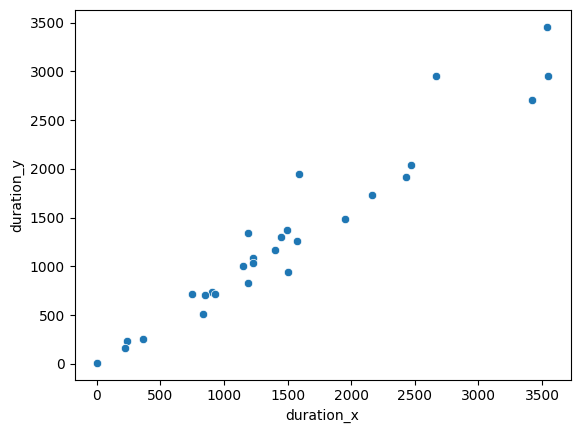

In [ ]:
## Compare labelled data daily usage to obs daily usage

import seaborn as sns

brush_dup = brush.assign(Cow_Mark=brush['obs_mark']).explode('Cow_Mark')
daily_usage=obs.groupby('Cow_Mark',as_index=False).agg({'duration': np.sum})
x=brush_dup.groupby('Cow_Mark',as_index=False).agg({'duration': np.sum})

daily_usage = pd.merge(daily_usage,x,how='left', on='Cow_Mark')


#daily_usage.plot(x='duration_x',y='duration_y', style='o')


daily_usage['duration_x']= daily_usage['duration_x']#.dt.total_seconds()
daily_usage['duration_y']= daily_usage['duration_y'].dt.total_seconds()

sns.scatterplot(x='duration_x',y='duration_y',data=daily_usage)


daily_usage['duration_x'].corr(daily_usage['duration_y'])



### **2.2.2 Checking the bout lablels**

As mentioned, the time difference between the rotation data (brush) and the observer data (CCTV camera) changes in time. The time synchronicity in data cleaning section has been done accordingly. In order to make sure the times are synch, we visualize the time difference between all pairs of start in the observer data and labelled event in the rotation data.

We noticed meaningful patterened changes in this time difference which indicated changes in time difference between two sources of data. We solved these problems step by step, targeting each of this changes as following:

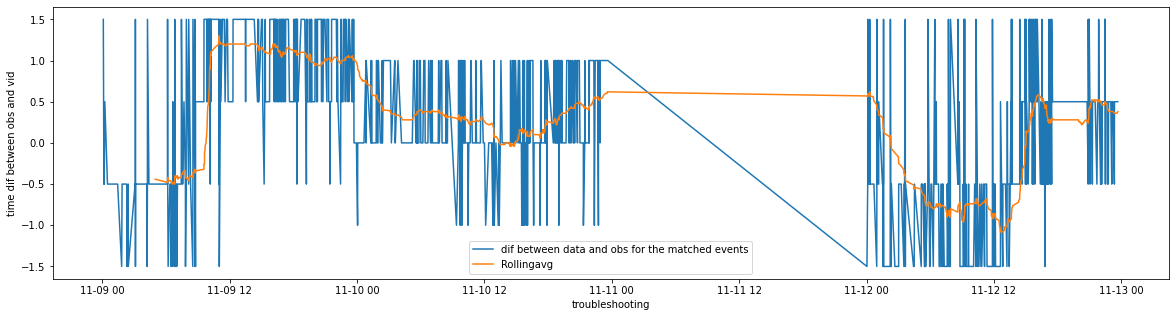

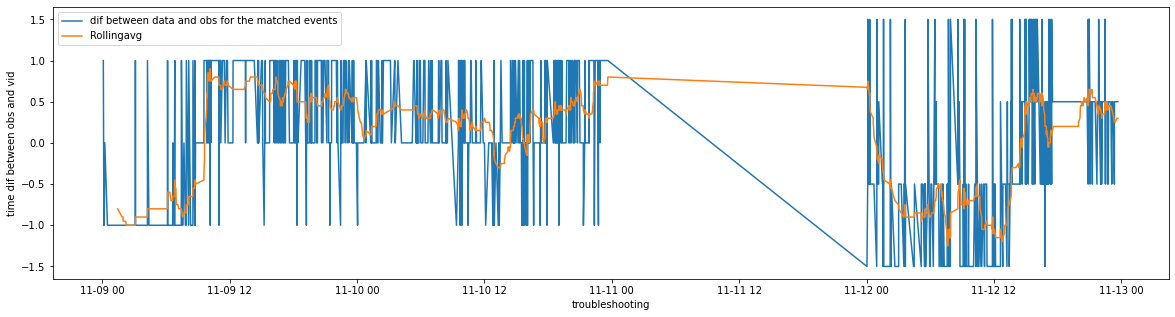
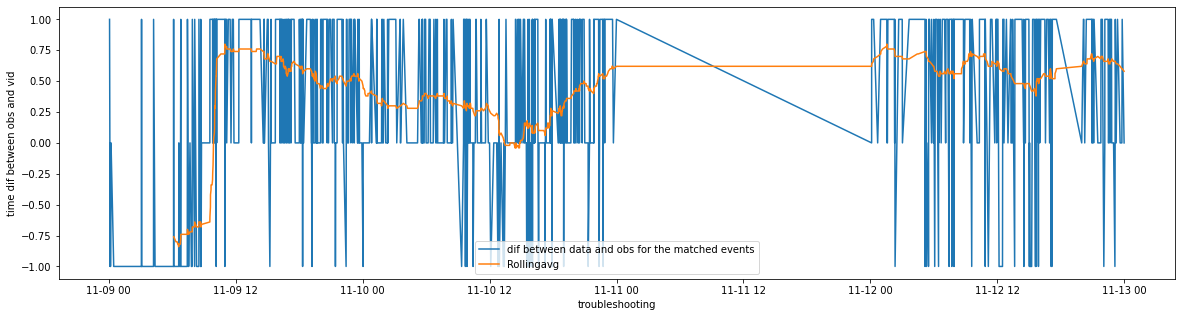

Text(0, 0.5, 'time dif between obs and vid')

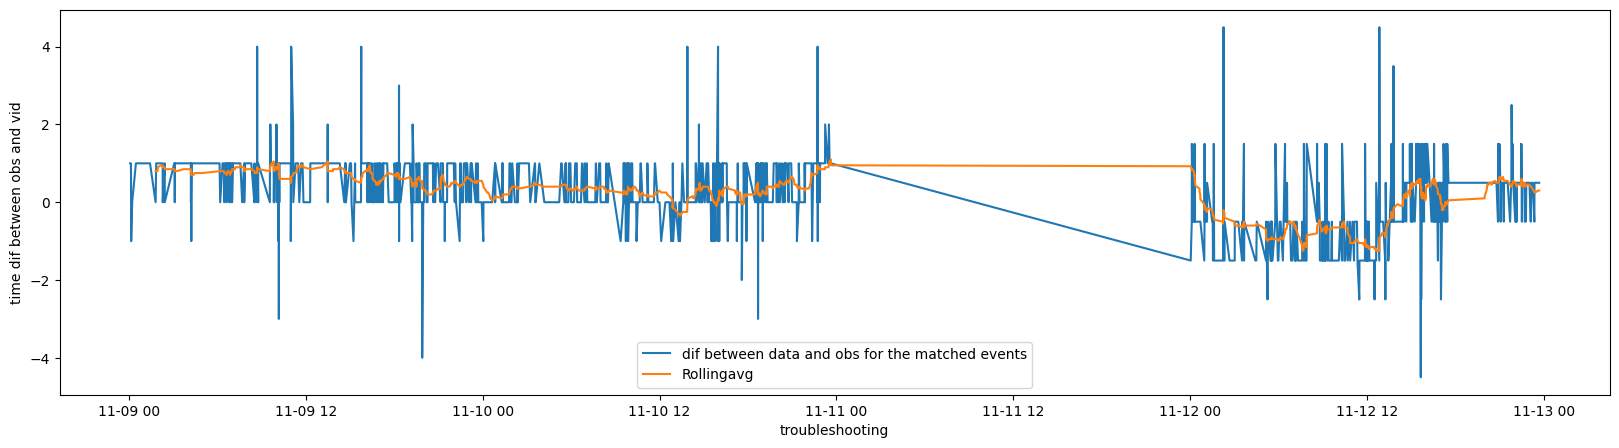

In [ ]:
##### plot the time difference between the matching points in time

import seaborn as sns
import matplotlib.pyplot as plt


bdat = brush[['obs_st','start']][brush.label==1].copy()
bdat['dif']= bdat['obs_st']-bdat['start']
bdat['dif']= bdat['dif'].dt.total_seconds()
bdat['dif_rolling_avg' ] = bdat.dif.rolling( 20).mean()


# set figure size
plt.figure( figsize = ( 20, 5))

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'start',
             y = 'dif',
             data = bdat,
             label = 'dif between data and obs for the matched events')

# plot using rolling average
sns.lineplot( x = 'start',
             y = 'dif_rolling_avg',
             data = bdat,
             label = 'Rollingavg')

plt.xlabel('troubleshooting')

plt.ylabel('time dif between obs and vid')

### **2.2.3 Unifyig the ID**




In [ ]:
# Change the barcodes and transponders and marks to the cow short id

# Import the cow marks
marks= pd.read_csv('/content/gdrive/MyDrive/brush_ML/cow_marks_nov2021.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)


# Import the cow transponder
trans= pd.read_csv('/content/gdrive/MyDrive/brush_ML/SHOW ID CREG.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
trans['CREG'] = trans['CREG'].astype(str).str[-8:]




barcodes = pd.merge(barcodes,marks[['cow_id','barcode']],how='left', left_on=['id'],right_on= ['barcode'])
barcodes = barcodes.dropna()
barcodes = barcodes.drop(columns={ 'id', 'frame', 'time2', 'barcode'})
barcodes['cow_id'] = barcodes['cow_id'].apply(pd.to_numeric)
barcodes = barcodes.rename(columns = {'time1':'start' , 'cow_id':'ID'})


rfid = pd.merge(rfid,trans[['CREG','ID']],how='left', left_on=['long_id'],right_on= ['CREG'])
rfid = rfid.drop(columns={'long_id', 'CREG'})
rfid['ID'] = rfid['ID'].apply(pd.to_numeric)




barcodes.to_csv('/content/gdrive/MyDrive/brush_ML/barcode_1112.csv')
rfid.to_csv('/content/gdrive/MyDrive/brush_ML/rfid_1112.csv')



<ipython-input-62-54c6b073d33f>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  marks= pd.read_csv('/content/gdrive/MyDrive/brush_ML/cow_marks_nov2021.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)
<ipython-input-62-54c6b073d33f>:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  trans= pd.read_csv('/content/gdrive/MyDrive/brush_ML/SHOW ID CREG.csv',delimiter=',', index_col=False, float_precision=None, error_bad_lines=False)


In [ ]:
brush_copy = brush.copy()

In [ ]:
brush_copy2 = brush.copy()

In [ ]:
# Split the obs_marks and create separate rows
brush_copy['index_org'] = brush_copy.index
brush_copy = brush_copy.explode('obs_mark')

In [ ]:
brush_copy = pd.merge(brush_copy,marks[['cow_id', 'mark']],how='left', left_on=['obs_mark'],right_on= ['mark'])


In [ ]:
# Group users of each event together again
#brush_copy.set_index('index_org')
#brush_copy['cow_id'] = brush_copy['cow_id'].astype(int)
#brush_copy = brush_copy.drop(columns= {'start','duration','gap','date'})
#brush_copy.reset_index(inplace = True)
#brush_new = brush_copy.groupby('index_org',as_index=False).apply(lambda x: x)
#brush_copy = brush_copy.apply(pd.DataFrame)


merged_id = brush_copy.groupby('index_org')['cow_id'].apply(set).reset_index()
brush_copy2['index_org'] = brush_copy2.index
brush_copy2 = pd.merge(brush_copy2,merged_id,how='left', on='index_org')

brush_copy2 =brush_copy2.drop(columns={'index_org','obs_mark','obs_st','obs_duration','id'})

# **3. Evaluation Functions**

## **3.1 Calculate Daily Usage and Correlation**

In [ ]:
def cal_correlation(brush,method_name):

  brush_pred = brush.explode('predicted_user')
  brush_obs = brush.explode('cow_id')

  # calculate predicted daily total
  daily_usage = brush_pred.groupby('predicted_user',
                                   as_index=False).agg({'duration': np.sum})
  daily_usage = daily_usage.rename(columns={'duration':'predicted_daily_total',
                                            'predicted_user': 'id'})
  daily_usage.id= daily_usage.id.astype(int)
  daily_usage['predicted_daily_total']= (daily_usage['predicted_daily_total']
                                         .dt.total_seconds())

  # calculate daily total
  daily_usage2 = brush_obs.groupby('cow_id',
                                   as_index=False).agg({'duration': np.sum})
  daily_usage2 = daily_usage2.rename(columns={'duration':'daily_total',
                                              'cow_id': 'id'})
  daily_usage2.id= daily_usage2.id.astype(int)
  daily_usage2['daily_total']= daily_usage2['daily_total'].dt.total_seconds()


  # merge two
  daily_usage = pd.merge(daily_usage,daily_usage2,how='left', on='id')

  daily_usage=daily_usage[daily_usage.id != 5090]
  #daily_usage=daily_usage[daily_usage.id != 5047]


  # calculate correlation
  cor = daily_usage['predicted_daily_total'].corr(daily_usage['daily_total'])

  # visualize results
  print(method_name)
  daily_usage.plot(x ='daily_total', y='predicted_daily_total',
                   xlabel = 'daily_total', ylabel='predicted_daily_total',
                   title = 'Agreement between observer and method',
                   legend= False,
                   style ='o')
  print('correlation = ',cor)

  return daily_usage



# **4. Bout Detection**

## **4.1 Unsupervised**

### **4.1.1 Data preprocessing**

#### **4.1.1.1 Dataset balancing**

In [ ]:
brush_data2 = brush_copy2.copy()

In [ ]:

from sklearn.model_selection import train_test_split

brush_data2['label'] = brush_data2['label'].replace(2.0,1.0)

# Shift "gap" column so that the gap for each event indicates the time
# before the start (but not after the end)
brush_data2['gap'] = brush_data2['gap'].shift(1)


train = brush_data2.drop(columns={'date'})


# train on 9 and 10 and test on 12
#test = brush_data2[brush_data2.date == pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
#train = brush_data2[brush_data2.date != pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
#test = test.drop(columns={'date'})
#train = train.drop(columns={'date'})

# number of start cases
#starts = len(train[train.label == 1])

# selecting the indices of the non-start classes
#start_indices = train[train.label == 1].index
#nonstart_indices = train[train.label.isna()].index

# from all non-start observations, randomly select observations equal to number of start observations
#random_nonstart_indices = np.random.choice(nonstart_indices, starts, replace = False)
#random_nonstart_indices = np.array(random_nonstart_indices)

# appending the 2 indices
#under_sample_indices = np.concatenate([start_indices,random_nonstart_indices])



#### **4.1.1.2 Dataset splitting**

In [ ]:
def add_prev_next_rows_2D(df, i, j):

    '''
    gets the data and adds i previous samples and j next samples as feature
    '''

    df = df[[ 'duration', 'gap']]    # choose which varibles you want to keep
                                    # could be direction duration gap
    df['duration']=df['duration'].dt.total_seconds()
    df['gap']=df['gap'].dt.total_seconds()

    for col in df.columns:
        for x in range(1,i+1):
            df[col+'_prev_'+str(x)] = df[col].shift(x)
        for y in range(1,j+1):
            df[col+'_next_'+str(y)] = df[col].shift(-y)
    return df

In [ ]:
# set the window size
window_size_prev = 2
window_size_after = 2

# now split X, y variables from the under sample data
X_train = train.loc[:, train.columns != 'label']
y_train = train.loc[:, train.columns == 'label'].fillna(0)

#X_test = test.loc[:, test.columns != 'label']
#y_test = test.loc[:, test.columns == 'label'].fillna(0)


X_train = add_prev_next_rows_2D(X_train, window_size_prev,window_size_after)


# undersample dataset
#X_train = X_train.loc[under_sample_indices,:]#.reset_index(drop=True)
#y_train = y_train.loc[under_sample_indices,:]#.reset_index(drop=True)

#remove NaN
stay = X_train.loc[~pd.isna(X_train).any(1), :].index
X_train = X_train.loc[stay,:]
y_train = y_train.loc[stay,:]


X_train_1 = X_train.copy()
y_train_1 = y_train.copy()


#remove gaps less than 1 seconds
stay = X_train.loc[X_train['gap']>1].index
X_train = X_train.loc[stay,:]
y_train = y_train.loc[stay,:]

X_train_1 = X_train_1.drop(index = stay)
y_train_1 = y_train_1.drop(index = stay)


#remove gaps less than 1 seconds
##stay = X_train.loc[X_train['gap']<1000].index
#X_train = X_train.loc[stay,:]
#y_train = y_train.loc[stay,:]

<ipython-input-18-e815ae0d5f9e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration']=df['duration'].dt.total_seconds()
<ipython-input-18-e815ae0d5f9e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gap']=df['gap'].dt.total_seconds()
<ipython-input-18-e815ae0d5f9e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
# split dataset
#X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size = 0.3, random_state = 0)


### **4.1.2 Machine Learning modeling**

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from scipy.stats.stats import ModeResult
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA




# Function to adjust labels
def adjust_labels(y_test, y_pred):
    y_test_mode = mode(y_test)[0][0]
    y_pred_mode = mode(y_pred)[0][0]
    y_pred_new = np.where(y_pred == y_pred_mode, y_test_mode, 1 - y_test_mode)
    return y_pred_new

# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    y_pred = adjust_labels(y_test, y_pred)

# Function to evaluate the model
#def evaluate_model(y_test, y_pred):
   # if np.mean(y_pred == y_test) < 0.5:
    #    y_pred = 1 - y_pred

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))



# Load dataset
X = X_train
y = y_train


# Preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)



# Define the models
models = [
    ("KMeans", KMeans(n_clusters=2)),
    ("AgglomerativeClustering", AgglomerativeClustering(n_clusters=2)),
    ("DBSCAN", DBSCAN(eps=0.3)),
]



for name, model in models:
    print(f"Running model: {name}")

    model.fit(X_train)

    # Predict
    y_pred = model.fit_predict(X_test)

    # In case of DBSCAN we need to handle the noise class (-1)
    if name == "DBSCAN":
        unique, counts = np.unique(y_pred, return_counts=True)
        if len(unique) > 2 or -1 in unique:
            print(f"DBSCAN resulted in more than two classes or noise, results may not be reliable for binary classification")

    evaluate_model(y_test, y_pred)
    print("\n" + "=" * 50 + "\n")



# Define the dimensionality reduction methods
dim_reduction_methods = [
    ("PCA", PCA(n_components=2))
    ]
 #   ("t-SNE", TSNE(n_components=2)),


for name, dr_method in dim_reduction_methods:
    X_train_reduced = dr_method.fit_transform(X_train)
    X_test_reduced = dr_method.transform(X_test)

    for model_name, model in models:
        print(f"Running model: {model_name} with dimensionality reduction: {name}")

        model.fit(X_train_reduced)

        # Predict
        y_pred = model.fit_predict(X_test_reduced)

        # In case of DBSCAN we need to handle the noise class (-1)
        if model_name == "DBSCAN":
            unique, counts = np.unique(y_pred, return_counts=True)
            if len(unique) > 2 or -1 in unique:
                print(f"DBSCAN resulted in more than two classes or noise, results may not be reliable for binary classification")

        evaluate_model(y_test, y_pred)
        print("\n" + "=" * 50 + "\n")


<ipython-input-21-cdcc72b3d64a>:8: DeprecationWarning: Please use `ModeResult` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import ModeResult
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running model: KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-21-cdcc72b3d64a>:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_test_mode = mode(y_test)[0][0]
<ipython-input-21-cdcc72b3d64a>:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the

Confusion Matrix:
[[713   1]
 [416   0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       714
         1.0       0.00      0.00      0.00       416

    accuracy                           0.63      1130
   macro avg       0.32      0.50      0.39      1130
weighted avg       0.40      0.63      0.49      1130



Running model: AgglomerativeClustering
Confusion Matrix:
[[713   1]
 [416   0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       714
         1.0       0.00      0.00      0.00       416

    accuracy                           0.63      1130
   macro avg       0.32      0.50      0.39      1130
weighted avg       0.40      0.63      0.49      1130



Running model: DBSCAN
DBSCAN resulted in more than two classes or noise, results may not be reliable for binary classification
Confusion Matrix:
[[516 198]
 [311 105]]
Classif

<ipython-input-21-cdcc72b3d64a>:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_test_mode = mode(y_test)[0][0]
<ipython-input-21-cdcc72b3d64a>:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_mode = mode(y_pred)[0][0]
/usr/local/lib/python3.10/dist-pac

Running model: KMeans with dimensionality reduction: PCA
Confusion Matrix:
[[700  14]
 [407   9]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77       714
         1.0       0.39      0.02      0.04       416

    accuracy                           0.63      1130
   macro avg       0.51      0.50      0.40      1130
weighted avg       0.54      0.63      0.50      1130



Running model: AgglomerativeClustering with dimensionality reduction: PCA
Confusion Matrix:
[[703  11]
 [410   6]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77       714
         1.0       0.35      0.01      0.03       416

    accuracy                           0.63      1130
   macro avg       0.49      0.50      0.40      1130
weighted avg       0.53      0.63      0.50      1130



Running model: DBSCAN with dimensionality reduction: PCA
DBSCAN resulted in more th

<ipython-input-21-cdcc72b3d64a>:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_test_mode = mode(y_test)[0][0]
<ipython-input-21-cdcc72b3d64a>:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_mode = mode(y_pred)[0][0]
<ipython-input-21-cdcc72b3d64a>:18

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1693 samples in 0.002s...
[t-SNE] Computed neighbors for 1693 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1693
[t-SNE] Computed conditional probabilities for sample 1693 / 1693
[t-SNE] Mean sigma: 0.018708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.605606
[t-SNE] KL divergence after 1000 iterations: 0.625757


[Text(0.5, 1.0, 'duration,gap,window=2')]

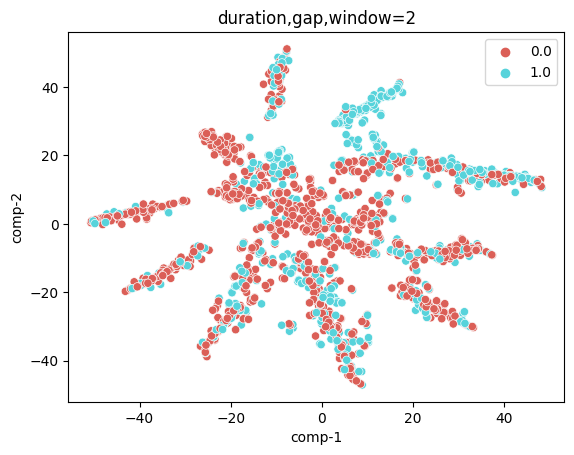

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd



tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_train)


df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="duration,gap,window=2")

In [ ]:
from sklearn.mixture import GaussianMixture

# Assume X is your feature matrix and y is your binary label vector (0 or 1)
#X = pd.concat([X_train, X_test], axis=0)
#y = pd.concat([y_train, y_test], axis=0)


# fit a GMM model to the data
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

# predict the probability of each data point belonging to each cluster
prob = gmm.predict_proba(X_train)

# set a threshold value for class membership
threshold = 0.6

# assign each data point to a class based on its probability
predictions = (prob[:, 0] > threshold).astype(int)
#prediction = np.expand_dims(predictions, axis=0)
predictions = predictions.reshape(-1,1)

# calculate accuracy
accuracy = (predictions == y_train).mean()
print(accuracy)



from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))


label    0.384525
dtype: float64
[[   1 1042]
 [   0  650]]
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      1043
         1.0       0.38      1.00      0.56       650

    accuracy                           0.38      1693
   macro avg       0.69      0.50      0.28      1693
weighted avg       0.76      0.38      0.21      1693



In [ ]:
from scipy.stats.stats import ModeResult
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Assume X is your feature matrix and y is your binary label vector (0 or 1)
#X = pd.concat([X_train, X_test], axis=0)
#y = pd.concat([y_train, y_test], axis=0)
#X = X_train
y = y_train

# fit a PCA model to the data
model = PCA(n_components=0.95)
X = model.fit_transform(X_train)

#df = pd.DataFrame()
#df["y"] = y_train
#df["comp-1"] = X[:,0]
#df["comp-2"] = X[:,1]

#sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                #palette=sns.color_palette("hls", 2),
                #data=df).set(title="duration,gap,window=2")


# Perform clustering on the t-SNE embedding
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(X)

#prediction = np.expand_dims(predictions, axis=0)
clusters = clusters.reshape(-1,1)

# calculate accuracy
accuracy = (clusters == y).mean()
print(accuracy)


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, clusters))
print(classification_report(y, clusters))


label    0.615475
dtype: float64
[[1042    1]
 [ 650    0]]
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76      1043
         1.0       0.00      0.00      0.00       650

    accuracy                           0.62      1693
   macro avg       0.31      0.50      0.38      1693
weighted avg       0.38      0.62      0.47      1693



<ipython-input-24-c17424001306>:1: DeprecationWarning: Please use `ModeResult` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import ModeResult
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, clusters))
print(classification_report(y, clusters))

[[1042    1]
 [ 650    0]]
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76      1043
         1.0       0.00      0.00      0.00       650

    accuracy                           0.62      1693
   macro avg       0.31      0.50      0.38      1693
weighted avg       0.38      0.62      0.47      1693



In [ ]:
from sklearn.mixture import BayesianGaussianMixture


# Assume X is your feature matrix and y is your binary label vector (0 or 1)
#X = pd.concat([X_train, X_test], axis=0)
#y = pd.concat([y_train, y_test], axis=0)
X = X_train
y = y_train


#X = StandardScaler().fit_transform(X)


# fit a GMM model to the data
gmm = BayesianGaussianMixture(n_components=2)
gmm.fit(X)

# predict the probability of each data point belonging to each cluster
prob = gmm.predict_proba(X)

# set a threshold value for class membership
threshold = 0.2

# assign each data point to a class based on its probability
predictions = (prob[:, 0] > threshold).astype(int)
#prediction = np.expand_dims(predictions, axis=0)
predictions = predictions.reshape(-1,1)

# calculate accuracy
accuracy = (predictions == y).mean()
print(accuracy)

#add the removed events (gap<1) for accuracy calculation
#y_train_1
#y_

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, predictions))
print(classification_report(y, predictions))


label    0.550502
dtype: float64
[[785 258]
 [503 147]]
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67      1043
         1.0       0.36      0.23      0.28       650

    accuracy                           0.55      1693
   macro avg       0.49      0.49      0.48      1693
weighted avg       0.51      0.55      0.52      1693



In [ ]:
from sklearn.mixture import BayesianGaussianMixture


# Assume X is your feature matrix and y is your binary label vector (0 or 1)
#X = pd.DataFrame(X_new)
#y = pd.concat([y_train, y_test], axis=0)
X = X_train
y = y_train



# fit a GMM model to the data
gmm = BayesianGaussianMixture(n_components=2)
gmm.fit(X)

# predict the probability of each data point belonging to each cluster
prob = gmm.predict_proba(X)

# set a threshold value for class membership
threshold = 0.1

# assign each data point to a class based on its probability
predictions = (prob[:, 0] > threshold).astype(int)
#prediction = np.expand_dims(predictions, axis=0)
predictions = predictions.reshape(-1,1)

# calculate accuracy
accuracy = (predictions == y).mean()
print(accuracy)





from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, predictions))
print(classification_report(y, predictions))


label    0.550502
dtype: float64
[[785 258]
 [503 147]]
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67      1043
         1.0       0.36      0.23      0.28       650

    accuracy                           0.55      1693
   macro avg       0.49      0.49      0.48      1693
weighted avg       0.51      0.55      0.52      1693



In [ ]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans


# Assume X is your feature matrix and y is your binary label vector (0 or 1)
#X = pd.DataFrame(X_new)
#y = pd.concat([y_train, y_test], axis=0)
X = X_train
y = y_train



# fit a Kmeans model to the data
kmeans = KMeans(n_clusters=2, random_state=1).fit(X)


# predict the probability of each data point belonging to each cluster
predictions = kmeans.labels_

# set a threshold value for class membership
threshold = 0.3




#prediction = np.expand_dims(predictions, axis=0)
predictions = predictions.reshape(-1,1)

# calculate accuracy
accuracy = (predictions == y).mean()
print(accuracy)



from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y, predictions))
print(classification_report(y, predictions))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


label    0.615475
dtype: float64
[[1042    1]
 [ 650    0]]
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76      1043
         1.0       0.00      0.00      0.00       650

    accuracy                           0.62      1693
   macro avg       0.31      0.50      0.38      1693
weighted avg       0.38      0.62      0.47      1693



In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


# Preprocess the data
X = X_train
y_true = y_train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering using k-means
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X_scaled)
cm = confusion_matrix(y_true, y_pred)
print("K-Means Clustering Confusion Matrix:")
print(cm)

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=2)
y_pred = hierarchical.fit_predict(X_scaled)
cm = confusion_matrix(y_true, y_pred)
print("Hierarchical Clustering Confusion Matrix:")
print(cm)

# Perform density-based clustering using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_pred = dbscan.fit_predict(X_scaled)
cm = confusion_matrix(y_true, y_pred)
print("Density-Based Clustering Confusion Matrix:")
print(cm)

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
y_pred = kmeans.fit_predict(X_pca)
cm = confusion_matrix(y_true, y_pred)
print("PCA Confusion Matrix:")
print(cm)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)
y_pred = kmeans.fit_predict(X_tsne)
cm = confusion_matrix(y_true, y_pred)
print("t-SNE Confusion Matrix:")
print(cm)

# Perform outlier detection using Isolation Forest
isolation_forest = IsolationForest(n_estimators=100)
y_pred = isolation_forest.fit_predict(X_scaled)
cm = confusion_matrix(y_true, y_pred)
print("Isolation Forest Confusion Matrix:")
print(cm)

# Perform outlier detection using Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X_scaled)
cm = confusion_matrix(y_true, y_pred)
print("Local Outlier Factor Confusion Matrix:")
print(cm)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Clustering Confusion Matrix:
[[1042    1]
 [ 650    0]]
Hierarchical Clustering Confusion Matrix:
[[1042    1]
 [ 650    0]]
Density-Based Clustering Confusion Matrix:
[[  0   0   0   0   0   0]
 [141 882   8   4   3   5]
 [ 90 554   1   3   2   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Confusion Matrix:
[[1032   11]
 [ 640   10]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


t-SNE Confusion Matrix:
[[441 602]
 [382 268]]
Isolation Forest Confusion Matrix:
[[   0    0    0]
 [  13    0 1030]
 [  15    0  635]]
Local Outlier Factor Confusion Matrix:
[[  0   0   0]
 [100   0 943]
 [ 70   0 580]]


## **4.2 Supervised**

### **4.2.1 Data preprocessing**

#### **4.2.1.1 Dataset balancing**

In [ ]:
brush_data2 = brush_copy2.copy()

In [ ]:

from sklearn.model_selection import train_test_split

brush_data2['label'] = brush_data2['label'].replace(2.0,1.0)

# Shift "gap" column so that the gap for each event indicates the time
# before the start (but not after the end)
brush_data2['gap'] = brush_data2['gap'].shift(1)


train = brush_data2.drop(columns={'date'})


# train on 9 and 10 and test on 12
test = brush_data2[brush_data2.date == pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
train = brush_data2[brush_data2.date != pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
test = test.drop(columns={'date'})
train = train.drop(columns={'date'})

# number of start cases
starts = len(train[train.label == 1])

# selecting the indices of the non-start classes
start_indices = train[train.label == 1].index
nonstart_indices = train[train.label.isna()].index

# from all non-start observations, randomly select observations equal to number of start observations
random_nonstart_indices = np.random.choice(nonstart_indices, starts, replace = False)
random_nonstart_indices = np.array(random_nonstart_indices)

# appending the 2 indices
under_sample_indices = np.concatenate([start_indices,random_nonstart_indices])



<ipython-input-23-5a97f496477a>:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  test = brush_data2[brush_data2.date == pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
<ipython-input-23-5a97f496477a>:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  train = brush_data2[brush_data2.date != pd.to_datetime("2021-11-12", format="%Y-%m-%d")]


#### **4.2.1.2 Dataset splitting**

In [ ]:
def add_prev_next_rows_2D(df, i, j):

    '''
    gets the data and adds i previous samples and j next samples as feature
    '''

    df = df[[ 'duration', 'gap']]    # choose which varibles you want to keep
                                    # could be direction duration gap
    df['duration']=df['duration'].dt.total_seconds()
    df['gap']=df['gap'].dt.total_seconds()

    for col in df.columns:
        for x in range(1,i+1):
            df[col+'_prev_'+str(x)] = df[col].shift(x)
        for y in range(1,j+1):
            df[col+'_next_'+str(y)] = df[col].shift(-y)
    return df

In [ ]:
# set the window size
window_size_prev = 2
window_size_after = 2

# now split X, y variables from the under sample data
X_train = train.loc[:, train.columns != 'label']
y_train = train.loc[:, train.columns == 'label'].fillna(0)

X_test = test.loc[:, test.columns != 'label']
y_test = test.loc[:, test.columns == 'label'].fillna(0)


X_train = add_prev_next_rows_2D(X_train, window_size_prev,window_size_after)
X_test = add_prev_next_rows_2D(X_test, window_size_prev,window_size_after)


# undersample dataset
X_train = X_train.loc[under_sample_indices,:]#.reset_index(drop=True)
y_train = y_train.loc[under_sample_indices,:]#.reset_index(drop=True)

#remove NaN train
stay = X_train.loc[~pd.isna(X_train).any(1), :].index
X_train = X_train.loc[stay,:]
y_train = y_train.loc[stay,:]


#remove NaN test
stay = X_test.loc[~pd.isna(X_test).any(1), :].index
X_test = X_test.loc[stay,:]
y_test = y_test.loc[stay,:]

#X_train_1 = X_train.copy()
#y_train_1 = y_train.copy()


#remove gaps less than 1 seconds
#stay = X_train.loc[X_train['gap']>1].index
#X_train = X_train.loc[stay,:]
#y_train = y_train.loc[stay,:]

#X_train_1 = X_train_1.drop(index = stay)
#y_train_1 = y_train_1.drop(index = stay)


#remove gaps less than 1 seconds
##stay = X_train.loc[X_train['gap']<1000].index
#X_train = X_train.loc[stay,:]
#y_train = y_train.loc[stay,:]

<ipython-input-24-e815ae0d5f9e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration']=df['duration'].dt.total_seconds()
<ipython-input-24-e815ae0d5f9e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gap']=df['gap'].dt.total_seconds()
<ipython-input-24-e815ae0d5f9e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

### **4.2.2 ML Modeling**

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

# Load a binary classification dataset
#X = X_train
#y = y_train

# Preprocess dataset, split into training and test part
#X = StandardScaler().fit_transform(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

# Define the models
models = [
    ("Support Vector Machine", SVC(gamma='scale')),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("Logistic Regression", LogisticRegression(solver='liblinear')),
]



# Define the models
models = [
    ("Support Vector Machine", SVC(gamma='scale')),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("Logistic Regression", LogisticRegression(solver='liblinear')),
]

for model_name, model in models:
    print(f"Running model: {model_name}")

    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    evaluate_model(y_test, y_pred)
    print("\n" + "=" * 50 + "\n")



# Apply PCA
dim_reduction_method = PCA(n_components=2)
X_train_reduced = dim_reduction_method.fit_transform(X_train)
X_test_reduced = dim_reduction_method.transform(X_test)

for model_name, model in models:
    print(f"Running model: {model_name} with PCA for dimensionality reduction")

    model.fit(X_train_reduced, y_train)

    # Predict
    y_pred = model.predict(X_test_reduced)

    evaluate_model(y_test, y_pred)
    print("\n" + "=" * 50 + "\n")


Running model: Support Vector Machine


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[8612   33]
 [ 313  128]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      8645
         1.0       0.80      0.29      0.43       441

    accuracy                           0.96      9086
   macro avg       0.88      0.64      0.70      9086
weighted avg       0.96      0.96      0.95      9086



Running model: Random Forest


<ipython-input-50-a4a745e2da57>:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Confusion Matrix:
[[8214  431]
 [  69  372]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      8645
         1.0       0.46      0.84      0.60       441

    accuracy                           0.94      9086
   macro avg       0.73      0.90      0.78      9086
weighted avg       0.97      0.94      0.95      9086



Running model: Logistic Regression
Confusion Matrix:
[[8480  165]
 [  76  365]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      8645
         1.0       0.69      0.83      0.75       441

    accuracy                           0.97      9086
   macro avg       0.84      0.90      0.87      9086
weighted avg       0.98      0.97      0.97      9086



Running model: Support Vector Machine with PCA for dimensionality reduction


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[8639    6]
 [ 313  128]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      8645
         1.0       0.96      0.29      0.45       441

    accuracy                           0.96      9086
   macro avg       0.96      0.64      0.71      9086
weighted avg       0.96      0.96      0.96      9086



Running model: Random Forest with PCA for dimensionality reduction


<ipython-input-50-a4a745e2da57>:64: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_reduced, y_train)


Confusion Matrix:
[[7710  935]
 [  72  369]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      8645
         1.0       0.28      0.84      0.42       441

    accuracy                           0.89      9086
   macro avg       0.64      0.86      0.68      9086
weighted avg       0.96      0.89      0.91      9086



Running model: Logistic Regression with PCA for dimensionality reduction
Confusion Matrix:
[[8492  153]
 [ 134  307]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8645
         1.0       0.67      0.70      0.68       441

    accuracy                           0.97      9086
   macro avg       0.83      0.84      0.83      9086
weighted avg       0.97      0.97      0.97      9086





/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<ipython-input-38-0cd4b305289d>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)


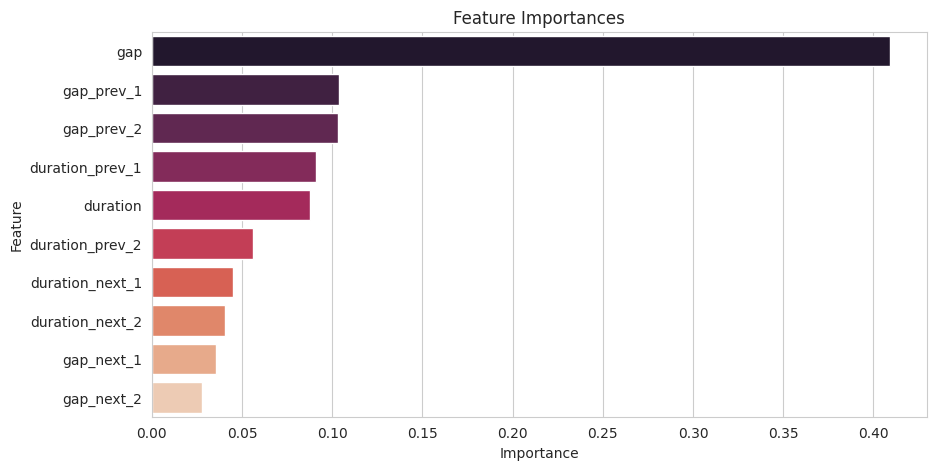

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# import data
X = X_train
y = y_train


# fit a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# get feature importances and sort them in descending order
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# create a bar plot of feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="rocket")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## **4.3 Label the test bouts with best models**

The best method was Logistic Regression and Random Forest

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))


# Define the model
model = LogisticRegression(solver='liblinear')


# Fit model
model.fit(X_train, y_train)


# Predict
y_pred = model.predict(X_test)

evaluate_model(y_test, y_pred)
print("\n" + "=" * 50 + "\n")


# two rows from beginning and end of the test
test = test.iloc[2:-2]
test['predicted_label'] = y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[8431  214]
 [  77  364]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      8645
         1.0       0.63      0.83      0.71       441

    accuracy                           0.97      9086
   macro avg       0.81      0.90      0.85      9086
weighted avg       0.97      0.97      0.97      9086





<ipython-input-26-86614c3b37b2>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_label'] = y_pred


# **5. Bout User Prediction**

## **5.1 Multiple Close Users**

In [ ]:
# Match barcode readings with the events

import itertools
import numpy as np

no_cow=0
extra_cow=0

#brush.label = brush.label.fillna(0)  #class 0 for non-start events
rfid = test.copy()

starts= test.index[test['predicted_label'] == 1].tolist()

for i in range(len(starts)-1):
  cows = barcodes_r[(brush.loc[starts[i],'start']<barcodes_r['time1']) & (barcodes_r['time1']<brush.loc[starts[i+1],'start'])]
  if cows.empty:   #the number of events that do not have readings within
    no_cow=no_cow+1
  if cows.size>1:   #the number of events that have more than 1 reading within
    extra_cow=extra_cow+1

    brush.loc[starts[i]:starts[i+1],'barcode'] = brush.loc[starts[i]:starts[i+1],'barcode'].apply(
      lambda x: cows['cow_id'].explode().unique() ,1)
    brush.loc[starts[i]:starts[i+1],'barcode_max_read'] = brush.loc[starts[i]:starts[i+1],'barcode'].apply(
      lambda x: cows['cow_id'].value_counts().idxmax() ,1)



### **5.1.1 RFID**

bout_multiclose_rfid
correlation =  0.49166247798072155


,id,predicted_daily_total,daily_total
0,5047,238.073,329.144
2,5139,125.211,591.162
3,6017,18.461,595.981
4,6023,50.913,481.599
5,6028,271.902,502.677
6,6076,181.483,147.323
7,6112,88.755,900.412
8,7034,34.805,412.022
9,7146,50.028,512.930
10,7147,22.651,651.227


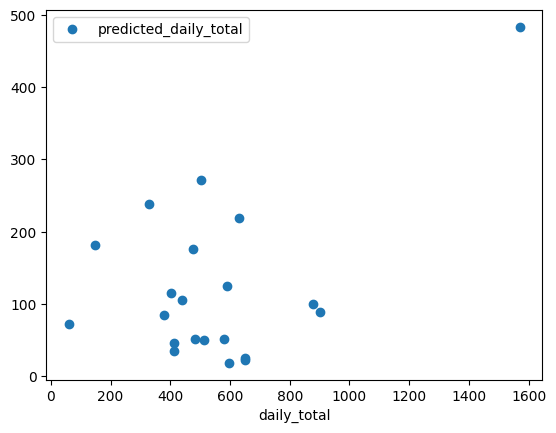

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

starts= test.index[test['predicted_label'] == 1].tolist()
test['predicted_user']=np.nan



for i in range(len(starts)-1):
  cows = rfid[(test.loc[starts[i],'start']<rfid['start']) & (rfid['start']<test.loc[starts[i+1],'start'])]
  if cows.empty:   #the number of events that do not have readings within
    no_cow=no_cow+1

  test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
    lambda x: cows['ID'].explode().unique() )
  #brush.loc[starts[i]:starts[i+1],'obs_id'] = brush.loc[starts[i],'cow_id'].item()
  #brush.loc[starts[i]:starts[i+1],'obs_id'].apply(
   # lambda x: brush.loc[starts[i],'obs_id'] )

  sum=sum+len(cows)

test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_multiclose_rfid')


### **5.1.2 ArUco**

bout_multiclose_barcode
correlation =  0.8731314910391377


,id,predicted_daily_total,daily_total
0,5047,181.655,329.144
2,5139,294.961,591.162
3,6017,232.637,595.981
4,6023,393.241,481.599
5,6028,307.900,502.677
6,6076,146.675,147.323
7,6112,417.179,900.412
8,7034,241.697,412.022
9,7146,438.251,512.930
10,7147,207.890,651.227


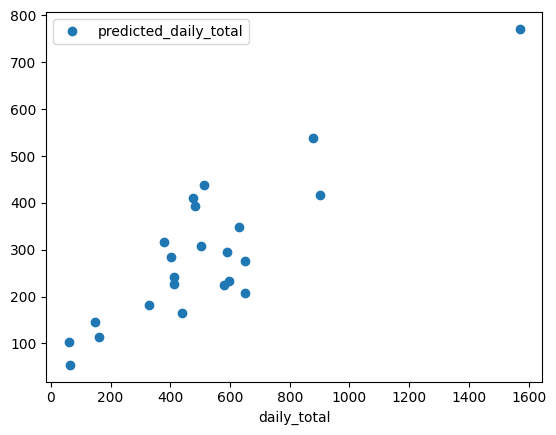

In [ ]:
# Match barcode readings with the events

import itertools
import numpy as np

sum=0
no_cow=0
extra_cow=0


test['predicted_user']=np.nan


starts= test.index[test['predicted_label'] == 1].tolist()

for i in range(len(starts)-1):
  cows = barcodes[(test.loc[starts[i],'start']<barcodes['start']) & (barcodes['start']<test.loc[starts[i+1],'start'])]
  if cows.empty:   #the number of events that do not have readings within
    no_cow=no_cow+1
  if cows.size>1:   #the number of events that have more than 1 reading within
    extra_cow=extra_cow+1

    #test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
     # lambda x: cows['ID'].explode().unique() ,1)
    test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
      lambda x: cows['ID'].value_counts().idxmax() ,1)

  sum=sum+len(cows)

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_multiclose_barcode')


## **5.2 Single Closest**

### **5.2.1 RFID**

bout_multiclose_rfid
correlation =  0.4234574925364632


,id,predicted_daily_total,daily_total
0,5047,998.987,329.144
2,5139,241.415,591.162
3,6017,172.368,595.981
4,6023,371.189,481.599
5,6028,794.814,502.677
6,6076,409.041,147.323
7,6112,1006.108,900.412
8,7034,298.423,412.022
9,7146,184.844,512.930
10,7147,132.359,651.227


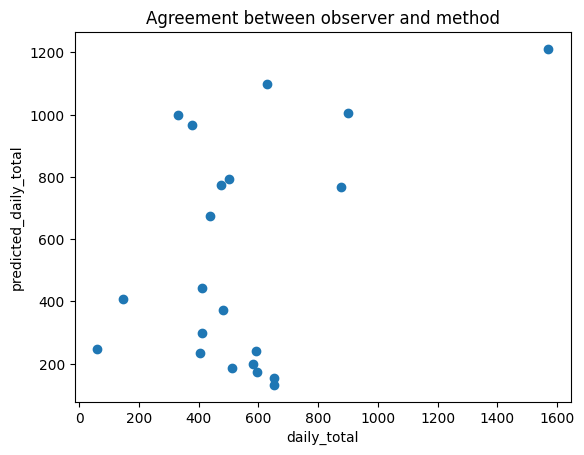

In [ ]:

import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

starts= test.index[test['predicted_label'] == 1].tolist()
test['predicted_user']=np.nan



for i in range(len(starts)-1):


  # Find the index of the row with the smallest time difference with the start
  closest_index = (rfid['start'] - test.loc[starts[i],'start']).abs().idxmin()

  test.loc[starts[i]:starts[i+1],'predicted_user'] = (test
                                                      .loc[starts[i]:starts[i+1],
                                                               'predicted_user']
                                                      .apply( lambda x: rfid
                                                             .loc[closest_index,'ID']
                                                              ,1))

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_multiclose_rfid')


### **5.2.2 ArUco**

bout_multiclose_barcode
correlation =  0.8212431120525633


,id,predicted_daily_total,daily_total
0,5047,369.031,329.144
2,5139,328.704,591.162
3,6017,548.570,595.981
4,6023,695.942,481.599
5,6028,332.931,502.677
6,6076,43.102,147.323
7,6112,834.408,900.412
8,7034,418.637,412.022
9,7146,522.335,512.930
10,7147,628.603,651.227


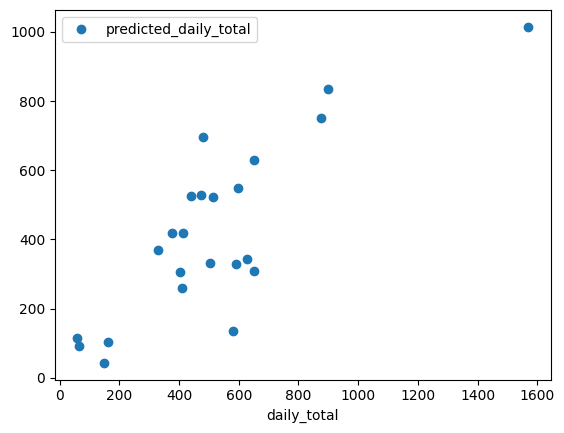

In [ ]:

import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

starts= test.index[test['predicted_label'] == 1].tolist()
test['predicted_user']=np.nan



for i in range(len(starts)-1):


  # Find the index of the row with the smallest time difference with the start
  closest_index = (barcodes['start'] - test.loc[starts[i],'start']).abs().idxmin()

  test.loc[starts[i]:starts[i+1],'predicted_user'] = (test
                                                      .loc[starts[i]:starts[i+1],
                                                               'predicted_user']
                                                      .apply( lambda x: barcodes
                                                             .loc[closest_index,'ID']
                                                              ,1))

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_multiclose_barcode')


## **5.2 Last Seen**

### **5.2.1 RFID**

bout_lastseen_rfid
correlation =  0.26693623783312825


,id,predicted_daily_total,daily_total
0,5047,1010.085,329.144
2,5139,242.936,591.162
3,6017,192.380,595.981
4,6023,137.113,481.599
5,6028,864.352,502.677
6,6076,591.990,147.323
7,6112,645.949,900.412
8,7034,201.698,412.022
9,7146,539.788,512.930
10,7147,111.829,651.227


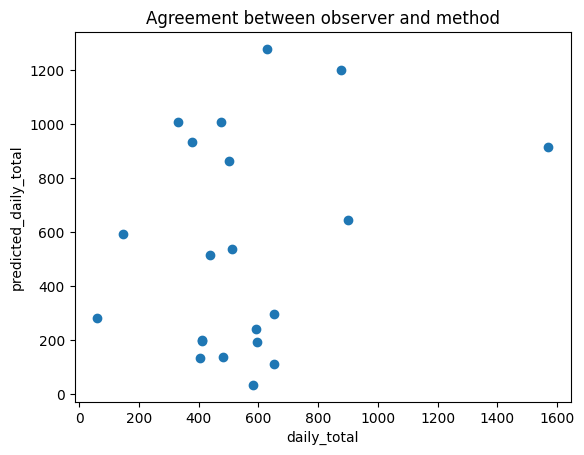

In [ ]:

import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

starts= test.index[test['predicted_label'] == 1].tolist()
test['predicted_user']=np.nan



for i in range(len(starts)-1):

  rfid_smaller = rfid[rfid['start']<test.loc[starts[i],'start']]


  # Find the index of the row with the smallest time difference with the start
  if not rfid_smaller.empty:
    closest_index = (rfid_smaller['start'] - test.loc[starts[i],'start']).abs().idxmin()

    test.loc[starts[i]:starts[i+1],'predicted_user'] = (test
                                                        .loc[starts[i]:starts[i+1],
                                                                'predicted_user']
                                                        .apply( lambda x: rfid_smaller
                                                              .loc[closest_index,'ID']
                                                                ,1))

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_lastseen_rfid')


### **5.2.2 ArUco**

bout_lastseen_barcode
correlation =  0.7628775801532149


,id,predicted_daily_total,daily_total
0,5047,54.214,329.144
2,5139,411.635,591.162
3,6017,705.756,595.981
4,6023,777.811,481.599
5,6028,178.460,502.677
6,6076,77.802,147.323
7,6112,792.921,900.412
8,7034,85.193,412.022
9,7146,348.799,512.930
10,7147,365.535,651.227


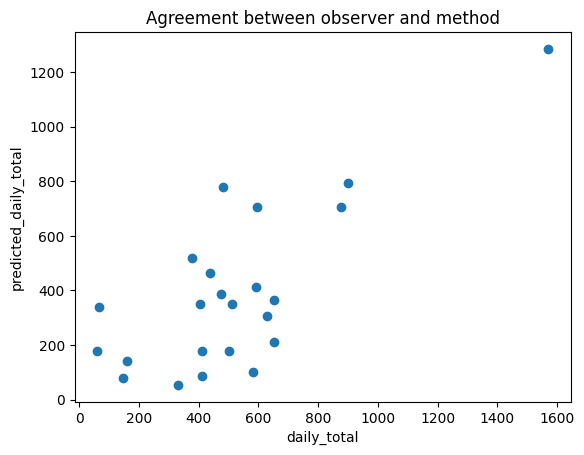

In [ ]:

import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

starts= test.index[test['predicted_label'] == 1].tolist()
test['predicted_user']=np.nan



for i in range(len(starts)-1):

  barcodes_smaller = barcodes[barcodes['start']<test.loc[starts[i],'start']]

  if not barcodes_smaller.empty :
    # Find the index of the row with the smallest time difference with the start
    closest_index = (barcodes_smaller['start'] - test.loc[starts[i],'start']).abs().idxmin()

    test.loc[starts[i]:starts[i+1],'predicted_user'] = (test
                                                        .loc[starts[i]:starts[i+1],
                                                                'predicted_user']
                                                        .apply( lambda x: barcodes_smaller
                                                              .loc[closest_index,'ID']
                                                                ,1))

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'bout_lastseen_barcode')


### **5.3.1 RFID**

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0
extra_cow=0


test['predicted_user']=np.nan


starts= test.index[test['predicted_label'] == 1].tolist()

for i in range(len(starts)-1):
  cows = barcodes[(brush.loc[starts[i],'start']<barcodes['start']) & (barcodes['start']<test.loc[starts[i+1],'start'])]
  if cows.empty:   #the number of events that do not have readings within
    no_cow=no_cow+1
  if cows.size>1:   #the number of events that have more than 1 reading within
    extra_cow=extra_cow+1

    #test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
     # lambda x: cows['ID'].explode().unique() ,1)
    test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
      lambda x: cows['ID'].value_counts().idxmax() ,1)

  sum=sum+len(cows)

cal_correlation(test, 'bout_closest_barcodes')


KeyError: ignored

### **5.3.2 ArUco**

In [ ]:
# Match RFID readings and the observervations with the events
# Match barcode readings with the events

import itertools
import numpy as np

sum=0
no_cow=0
extra_cow=0


test['predicted_user']=np.nan


starts= test.index[test['predicted_label'] == 1].tolist()

for i in range(len(starts)-1):
  cows = barcodes[(brush.loc[starts[i],'start']<barcodes['start']) & (barcodes['start']<test.loc[starts[i+1],'start'])]
  if cows.empty:   #the number of events that do not have readings within
    no_cow=no_cow+1
  if cows.size>1:   #the number of events that have more than 1 reading within
    extra_cow=extra_cow+1

    #test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
     # lambda x: cows['ID'].explode().unique() ,1)
    test.loc[starts[i]:starts[i+1],'predicted_user'] = test.loc[starts[i]:starts[i+1],'predicted_user'].apply(
      lambda x: cows['ID'].value_counts().idxmax() ,1)

  sum=sum+len(cows)

cal_correlation(test, 'bout_closest_barcodes')


KeyError: ignored

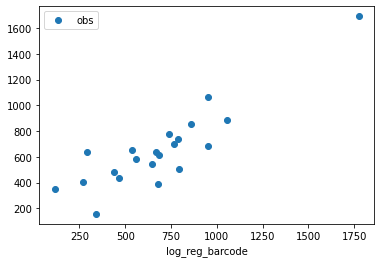

In [ ]:
daily_usage.plot(x='log_reg_barcode', y='obs', style='o')

# **6. Event User Prediction**

## **6.1 Single Closest**

### **6.1.1 RFID**

bout_multiclose_rfid
correlation =  0.4434558849561019


,id,predicted_daily_total,daily_total
0,5047,987.452,329.144
2,5139,243.729,591.162
3,6017,172.368,595.981
4,6023,370.684,481.599
5,6028,755.041,502.677
6,6076,436.600,147.323
7,6112,1006.108,900.412
8,7034,296.395,412.022
9,7146,184.844,512.930
10,7147,133.113,651.227


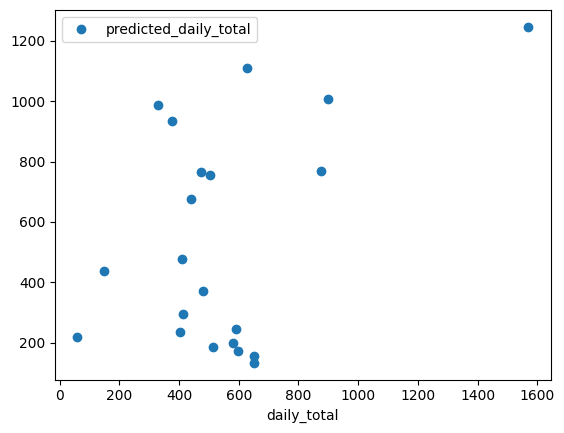

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

test['predicted_user']=np.nan

for i,row in test.iterrows():

  # Find the index of the closest detection to the start
  closest_index = (rfid['start'] - test.loc[i,'start']).abs().idxmin()

  test.loc[i,'predicted_user'] = rfid.loc[closest_index,'ID']

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'event_singleclose_rfid')


### **6.1.2 ArUco**

event_singleclose_barcodes
correlation =  0.8391592831484654


,id,predicted_daily_total,daily_total
0,5047,401.902,329.144
2,5139,342.134,591.162
3,6017,541.428,595.981
4,6023,711.693,481.599
5,6028,323.129,502.677
6,6076,46.837,147.323
7,6112,847.848,900.412
8,7034,417.613,412.022
9,7146,505.360,512.930
10,7147,610.042,651.227


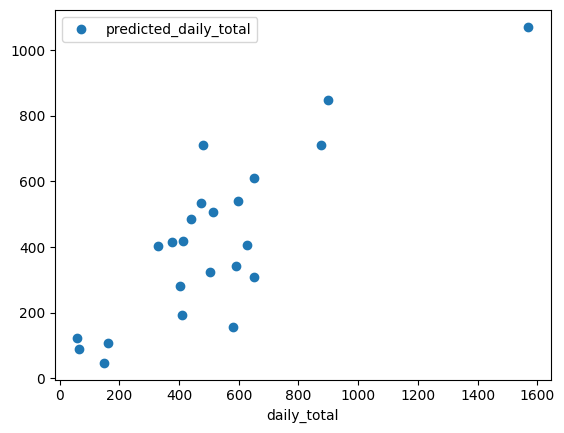

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

test['predicted_user']=np.nan

for i,row in test.iterrows():

  # Find the index of the closest detection to the start
  closest_index = (barcodes['start'] - test.loc[i,'start']).abs().idxmin()

  test.loc[i,'predicted_user'] = barcodes.loc[closest_index,'ID']

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'event_singleclose_barcodes')

## **6.1 Last Seen**

### **6.1.1 RFID**

event_lastseen_rfid
correlation =  0.3017012335919236


,id,predicted_daily_total,daily_total
0,5047,1031.653,329.144
2,5139,243.183,591.162
3,6017,203.029,595.981
4,6023,145.574,481.599
5,6028,891.776,502.677
6,6076,569.886,147.323
7,6112,630.479,900.412
8,7034,194.712,412.022
9,7146,531.690,512.930
10,7147,111.902,651.227


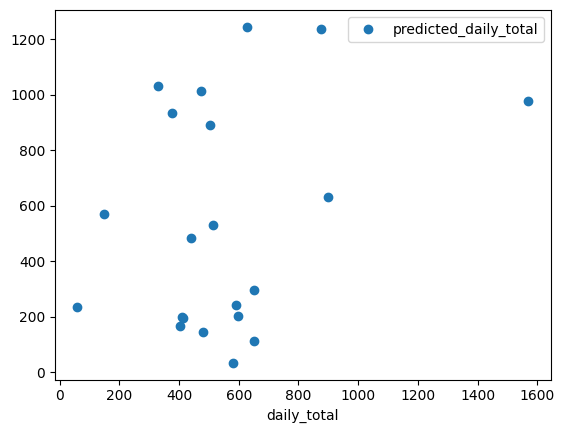

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

test['predicted_user']=np.nan

for i,row in test.iterrows():

  # Find the index of the closest detection to the start
  rfid_smaller = rfid[rfid['start']<test.loc[i,'start']]
  if rfid_smaller.empty:
    pass
  else:
    closest_index = (rfid_smaller['start'] - test.loc[i,'start']).abs().idxmin()

    test.loc[i,'predicted_user'] = rfid_smaller.loc[closest_index,'ID']

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'event_lastseen_rfid')


### **6.1.2 ArUco**

event_lastseen_barcode
correlation =  0.7801306201928205


,id,predicted_daily_total,daily_total
0,5047,92.583,329.144
2,5139,405.616,591.162
3,6017,705.412,595.981
4,6023,767.801,481.599
5,6028,272.955,502.677
6,6076,74.295,147.323
7,6112,805.509,900.412
8,7034,92.600,412.022
9,7146,396.778,512.930
10,7147,409.715,651.227


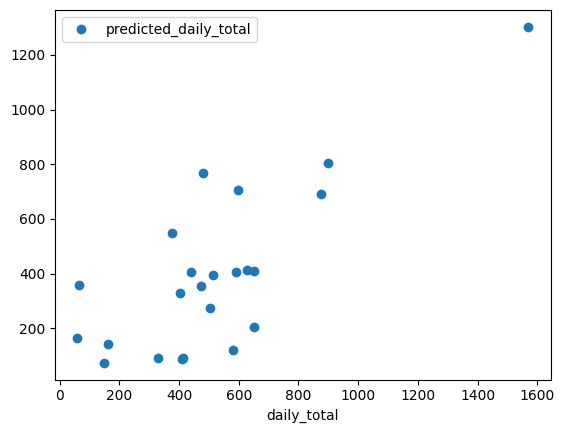

In [ ]:
import itertools
import numpy as np

sum=0
no_cow=0

#test.label = test.label.fillna(0)  #class 0 for non-start events

test['predicted_user']=np.nan

for i,row in test.iterrows():

  # Find the index of the closest detection to the start
  barcodes_smaller = barcodes[barcodes['start']<test.loc[i,'start']]
  if barcodes_smaller.empty:
    print('hey')
  else:
    closest_index = (barcodes_smaller['start'] - test.loc[i,'start']).abs().idxmin()

    test.loc[i,'predicted_user'] = barcodes_smaller.loc[closest_index,'ID']

#test['predicted_user'] = test['predicted_user'].fillna(method='ffill')

cal_correlation(test, 'event_lastseen_barcode')


## **6.2 ML**

## **5.3.1 Data Preparation**

For each bout/event we find the 4 cows who are detected closest to the middle of the bout/event. The gap between these four and the bout/event is used as input to the ML models.

In [ ]:
def four_closest(target_time, detections):

  """
  gets a specific time and returns the id of the four cows detected closest
  to that time in addition to the time difference.


  """
  detect = detections.copy()

  # Calculate the time difference
  detect['time_difference'] = abs(detect['start'] - target_time)
  detect['time_difference'] = (abs(detect['start']
                                       - target_time).dt.total_seconds())


  # Sort the DataFrame by time difference in ascending order
  # and keep the closest detection of each cow
  df_sorted = detect.sort_values(by='time_difference').groupby('ID').head(1)

  # Get the indices of the four closest datetime values
  closest_indices = df_sorted.index[:4]

  # Return the id and time difference
  return detect.loc[closest_indices,['time_difference','ID']]



In [ ]:
brush_data2 = brush_copy2.copy()

In [ ]:

from sklearn.model_selection import train_test_split

brush_data2['label'] = brush_data2['label'].replace(2.0,1.0)

# Shift "gap" column so that the gap for each event indicates the time
# before the start (but not after the end)
brush_data2['gap'] = brush_data2['gap'].shift(1)


train = brush_data2.drop(columns={'date'})


# train on 9 and 10 and test on 12
test = brush_data2[brush_data2.date == pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
train = brush_data2[brush_data2.date != pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
test = test.drop(columns={'date'})
train = train.drop(columns={'date'})


<ipython-input-138-e4fd81f83885>:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  test = brush_data2[brush_data2.date == pd.to_datetime("2021-11-12", format="%Y-%m-%d")]
<ipython-input-138-e4fd81f83885>:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  train = brush_data2[brush_data2.date != pd.to_datetime("2021-11-12", format="%Y-%m-%d")]


For each event:
- Input is four integers -> the time difference between the middle of the bout and the detection
- Output is four binary values -> if that cow is the user or not

## **ArUco**

In [ ]:

train = pd.DataFrame(index=test.index,
                     columns =['one_t','two_t','three_t','four_t',
                               'one_is_user','two_is_user','three_is_user',
                               'four_is_user'] )

#train['one_id','two_id','three_id','four_id'] = ['','','','']


for i,row in test.iterrows():

  #Find the middle of the event
  target_time = test.loc[i,'start'] + test.loc[i,'duration']/2

  # Find the four closest cows
  closest = four_closest(target_time,barcodes)

  # Time differences added to data ((as input to the ML))
  train.loc[i, ['one_t','two_t','three_t','four_t']] = closest['time_difference'].tolist()
  #train.loc[i, ['one_id','two_id','three_id','four_id']] = closest['ID']

  # check if each of the four cows are real users and create a binary list
  # accordingly (as output of the ML)
  binary_list = [1 if item in test.loc[i,'cow_id'] else 0 for item in closest['ID']]
  train.loc[i, ['one_is_user','two_is_user','three_is_user','four_is_user']] = binary_list





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))


# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets],
                                                    test_size=0.5,
                                                    random_state=42,
                                                    shuffle=False)

# Train a separate model for each output
for target in targets:
    print(f"Training model for {target}")

    # Create and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target].astype('int'))

    # Use the model to make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test[target].astype('int'), predictions)
    print(f"Accuracy: {accuracy}")

    evaluate_model(y_test[target].astype('int'), predictions)



Training model for one_is_user
Accuracy: 0.9683168316831683
Confusion Matrix:
[[2202   56]
 [  88 2199]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2258
           1       0.98      0.96      0.97      2287

    accuracy                           0.97      4545
   macro avg       0.97      0.97      0.97      4545
weighted avg       0.97      0.97      0.97      4545

Training model for two_is_user
Accuracy: 0.9674367436743674
Confusion Matrix:
[[3592   40]
 [ 108  805]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3632
           1       0.95      0.88      0.92       913

    accuracy                           0.97      4545
   macro avg       0.96      0.94      0.95      4545
weighted avg       0.97      0.97      0.97      4545

Training model for three_is_user
Accuracy: 0.9834983498349835
Confusion Matrix:
[[4239   1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, jaccard_score
from keras.models import Sequential
from keras.layers import Dense



# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets].astype(int),
                                                    test_size=0.5,
                                                    random_state=42)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-output Random Forest
print("Training Multi-output Random Forest")
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)
predictions = multi_target_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")

# Multi-output Neural Network
print("\nTraining Multi-output Neural Network")
model = Sequential()
model.add(Dense(10, input_dim=len(features), activation='relu'))
model.add(Dense(len(targets), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=0)

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Accuracy: {accuracy}')

# Neural network does not directly give discrete predictions,
#so we need to threshold the output
nn_predictions = (model.predict(X_test_scaled) > 0.5).astype(int)

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], nn_predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, nn_predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")

Training Multi-output Random Forest
Accuracy: 0.9364136413641364
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2258
           1       0.97      0.96      0.97      2287

    accuracy                           0.97      4545
   macro avg       0.97      0.97      0.97      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[2198   60]
 [  81 2206]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3632
           1       0.96      0.89      0.92       913

    accuracy                           0.97      4545
   macro avg       0.97      0.94      0.95      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[3597   35]
 [ 104  809]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6787678599357605
143/143 [==============================] - 0s 1ms/step
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      2258
           1       0.72      0.66      0.69      2287

    accuracy                           0.70      4545
   macro avg       0.70      0.70      0.70      4545
weighted avg       0.70      0.70      0.70      4545

Confusion Matrix:
[[2198   60]
 [  81 2206]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      3632
           1       0.49      0.15      0.23       913

    accuracy                           0.80      4545
   macro avg       0.65      0.56      0.56      4545
weighted avg       0.75      0.80      0.75      4545

Confusion Matrix:
[[3597   35]
 [ 104  809]]
Classification report for three_is_user:
              precision    recall  f1-score   support

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

## **Inference**

Try the best model
**-- MultioutputRandom Forest --** to test on 6 hours of data:

- train the model on 0-12pm
- test on 12-24
- label the predicted users on event data
- calculate the usage and correlation







In [ ]:
ML_data = pd.DataFrame(index=test.index,
                     columns =['one_t','two_t','three_t','four_t',
                               'one_is_user','two_is_user','three_is_user',
                               'four_is_user','one_id','two_id',
                               'three_id','four_id'])




for i,row in test.iterrows():

  #Find the middle of the event
  target_time = test.loc[i,'start'] + test.loc[i,'duration']/2

  # Find the four closest cows
  closest = four_closest(target_time,barcodes)

  # Time differences added to data ((as input to the ML))
  ML_data.loc[i, ['one_t','two_t','three_t','four_t']] = closest['time_difference'].tolist()
  ML_data.loc[i, ['one_id','two_id','three_id','four_id']] = closest['ID'].tolist()

  # check if each of the four cows are real users and create a binary list
  # accordingly (as output of the ML)
  binary_list = [1 if item in test.loc[i,'cow_id'] else 0 for item in closest['ID']]
  ML_data.loc[i, ['one_is_user','two_is_user','three_is_user','four_is_user']] = binary_list




In [ ]:
ML_data2 = ML_data.copy()

In [ ]:
train = ML_data2.copy()


# Split the data into a training set and a test set
data_test = test.index[test['start']>pd.to_datetime("2021-11-12 12:00:00",
                                                    format="%Y-%m-%d %H:%M:%S")]
data_train = test.index[test['start']<pd.to_datetime("2021-11-12 12:00:00",
                                                     format="%Y-%m-%d %H:%M:%S")]
train = train.loc[data_train]




# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets].astype(int),
                                                    test_size=0.99,
                                                    random_state=42)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Multi-output Random Forest
print("Training Multi-output Random Forest")
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)
predictions = multi_target_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")




print('************************************************************')
train = ML_data2.copy()
new_test = train.loc[data_test]

from sklearn.utils import shuffle
new_test = shuffle(new_test,random_state=2)


# Seperate X and y
X_test = new_test.loc[:, features]
y_test = new_test.loc[:, targets].astype(int)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-output Random Forest
#print("Training Multi-output Random Forest")
#forest = RandomForestClassifier(random_state=1)
#multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
#multi_target_forest.fit(X_train, y_train)
predictions = multi_target_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")




Training Multi-output Random Forest
Accuracy: 0.6853675291962446
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1887
           1       0.75      0.83      0.79      2480

    accuracy                           0.74      4367
   macro avg       0.74      0.73      0.73      4367
weighted avg       0.74      0.74      0.74      4367

Confusion Matrix:
[[1182  705]
 [ 412 2068]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3831
           1       0.74      0.12      0.20       536

    accuracy                           0.89      4367
   macro avg       0.82      0.56      0.57      4367
weighted avg       0.87      0.89      0.85      4367

Confusion Matrix:
[[3809   22]
 [ 473   63]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy: 0.33169480658260314
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      2678
           1       0.42      0.63      0.51      2001

    accuracy                           0.47      4679
   macro avg       0.49      0.49      0.47      4679
weighted avg       0.50      0.47      0.46      4679

Confusion Matrix:
[[ 925 1753]
 [ 731 1270]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      3358
           1       0.35      0.01      0.02      1321

    accuracy                           0.72      4679
   macro avg       0.53      0.50      0.43      4679
weighted avg       0.61      0.72      0.60      4679

Confusion Matrix:
[[3334   24]
 [1308   13]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier




# Split the data into a training set and a test set
data_test = test.index[test['start']>pd.to_datetime("2021-11-12 12:00:00",
                                                    format="%Y-%m-%d %H:%M:%S")]
data_train = test.index[test['start']<pd.to_datetime("2021-11-12 12:00:00",
                                                     format="%Y-%m-%d %H:%M:%S")]
train = train.loc[data_train]


# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']




train = ML_data2.copy()


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets].astype(int),
                                                    test_size=0.5,
                                                    random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




# Define the classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), random_state=42),
}



# Train and evaluate each model
for name, classifier in classifiers.items():
    print(f"Training {name}")



    # Create and train the multi-output model
    multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
    multi_target_classifier.fit(X_train, y_train)

    # Use the model to make predictions
    predictions = multi_target_classifier.predict(X_test)


    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Print classification report for each target
    for i, target in enumerate(targets):
        print(f"Classification report for {target}:")
        print(classification_report(y_test.iloc[:, i], predictions[:, i]))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

    # Print average Jaccard score
    jaccard = jaccard_score(y_test, predictions, average='samples')
    print(f"Average Jaccard Score: {jaccard}")





    print('************************************************************')
    new_test = ML_data2.loc[data_test].copy()

    from sklearn.utils import shuffle
    new_test = shuffle(new_test,random_state=2)


    # Seperate X and y
    X_test = new_test.loc[:, features]
    y_test = new_test.loc[:, targets].astype(int)


    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Multi-output Random Forest
    #print("Training Multi-output Random Forest")
    #forest = RandomForestClassifier(random_state=1)
    #multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
    #multi_target_forest.fit(X_train, y_train)
    predictions = multi_target_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Print classification report for each target
    for i, target in enumerate(targets):
        print(f"Classification report for {target}:")
        print(classification_report(y_test.iloc[:, i], predictions[:, i]))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

    # Print average Jaccard score
    jaccard = jaccard_score(y_test, predictions, average='samples')
    print(f"Average Jaccard Score: {jaccard}")




Training Random Forest
Accuracy: 0.9342134213421343
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2258
           1       0.98      0.96      0.97      2287

    accuracy                           0.97      4545
   macro avg       0.97      0.97      0.97      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[2202   56]
 [  88 2199]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3632
           1       0.95      0.88      0.92       913

    accuracy                           0.97      4545
   macro avg       0.96      0.94      0.95      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[3592   40]
 [ 108  805]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.99      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.953622568924984
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2678
           1       0.99      0.97      0.98      2001

    accuracy                           0.98      4679
   macro avg       0.98      0.98      0.98      4679
weighted avg       0.98      0.98      0.98      4679

Confusion Matrix:
[[2650   28]
 [  59 1942]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3358
           1       0.98      0.94      0.96      1321

    accuracy                           0.98      4679
   macro avg       0.98      0.97      0.97      4679
weighted avg       0.98      0.98      0.98      4679

Confusion Matrix:
[[3327   31]
 [  79 1242]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Jaccard Score: 0.7458502529030419
Training Gradient Boosting
Accuracy: 0.668946356058987
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2678
           1       0.79      0.78      0.78      2001

    accuracy                           0.81      4679
   macro avg       0.81      0.81      0.81      4679
weighted avg       0.81      0.81      0.81      4679

Confusion Matrix:
[[2256  422]
 [ 450 1551]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      3358
           1       0.86      0.55      0.67      1321

    accuracy                           0.85      4679
   macro avg       0.85      0.76      0.79      4679
weighted avg       0.85      0.85      0.84      4679

Confusion Matrix:
[[3242  116]
 [ 590  731]]
Classification report for three_is_user:
              precision    recall  f1-sc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.668946356058987
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2678
           1       0.79      0.78      0.78      2001

    accuracy                           0.81      4679
   macro avg       0.81      0.81      0.81      4679
weighted avg       0.81      0.81      0.81      4679

Confusion Matrix:
[[2256  422]
 [ 450 1551]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      3358
           1       0.86      0.55      0.67      1321

    accuracy                           0.85      4679
   macro avg       0.85      0.76      0.79      4679
weighted avg       0.85      0.85      0.84      4679

Confusion Matrix:
[[3242  116]
 [ 590  731]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.43428082923701644
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.65      0.91      0.75      2678
           1       0.73      0.33      0.46      2001

    accuracy                           0.66      4679
   macro avg       0.69      0.62      0.61      4679
weighted avg       0.68      0.66      0.63      4679

Confusion Matrix:
[[2425  253]
 [1332  669]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3358
           1       0.69      0.45      0.55      1321

    accuracy                           0.79      4679
   macro avg       0.75      0.69      0.70      4679
weighted avg       0.78      0.79      0.77      4679

Confusion Matrix:
[[3089  269]
 [ 724  597]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Training Random Forest
Accuracy: 0.9342134213421343
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2258
           1       0.98      0.96      0.97      2287

    accuracy                           0.97      4545
   macro avg       0.97      0.97      0.97      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[2202   56]
 [  88 2199]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3632
           1       0.95      0.88      0.92       913

    accuracy                           0.97      4545
   macro avg       0.96      0.94      0.95      4545
weighted avg       0.97      0.97      0.97      4545

Confusion Matrix:
[[3592   40]
 [ 108  805]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.99      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.953622568924984
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2678
           1       0.99      0.97      0.98      2001

    accuracy                           0.98      4679
   macro avg       0.98      0.98      0.98      4679
weighted avg       0.98      0.98      0.98      4679

Confusion Matrix:
[[2650   28]
 [  59 1942]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3358
           1       0.98      0.94      0.96      1321

    accuracy                           0.98      4679
   macro avg       0.98      0.97      0.97      4679
weighted avg       0.98      0.98      0.98      4679

Confusion Matrix:
[[3327   31]
 [  79 1242]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


event_ML_barcode
correlation =  0.7511350021527574
Training Gradient Boosting
Accuracy: 0.668946356058987
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2678
           1       0.79      0.78      0.78      2001

    accuracy                           0.81      4679
   macro avg       0.81      0.81      0.81      4679
weighted avg       0.81      0.81      0.81      4679

Confusion Matrix:
[[2256  422]
 [ 450 1551]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      3358
           1       0.86      0.55      0.67      1321

    accuracy                           0.85      4679
   macro avg       0.85      0.76      0.79      4679
weighted avg       0.85      0.85      0.84      4679

Confusion Matrix:
[[3242  116]
 [ 590  731]]
Classification report for three_is_user:
              precision    reca

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.668946356058987
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2678
           1       0.79      0.78      0.78      2001

    accuracy                           0.81      4679
   macro avg       0.81      0.81      0.81      4679
weighted avg       0.81      0.81      0.81      4679

Confusion Matrix:
[[2256  422]
 [ 450 1551]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      3358
           1       0.86      0.55      0.67      1321

    accuracy                           0.85      4679
   macro avg       0.85      0.76      0.79      4679
weighted avg       0.85      0.85      0.84      4679

Confusion Matrix:
[[3242  116]
 [ 590  731]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


event_ML_barcode
correlation =  0.7425077389618604
Training MLP
Accuracy: 0.43428082923701644
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.65      0.91      0.75      2678
           1       0.73      0.33      0.46      2001

    accuracy                           0.66      4679
   macro avg       0.69      0.62      0.61      4679
weighted avg       0.68      0.66      0.63      4679

Confusion Matrix:
[[2425  253]
 [1332  669]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3358
           1       0.69      0.45      0.55      1321

    accuracy                           0.79      4679
   macro avg       0.75      0.69      0.70      4679
weighted avg       0.78      0.79      0.77      4679

Confusion Matrix:
[[3089  269]
 [ 724  597]]
Classification report for three_is_user:
              precision    recall  f1-score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy: 0.43428082923701644
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.65      0.91      0.75      2678
           1       0.73      0.33      0.46      2001

    accuracy                           0.66      4679
   macro avg       0.69      0.62      0.61      4679
weighted avg       0.68      0.66      0.63      4679

Confusion Matrix:
[[2425  253]
 [1332  669]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3358
           1       0.69      0.45      0.55      1321

    accuracy                           0.79      4679
   macro avg       0.75      0.69      0.70      4679
weighted avg       0.78      0.79      0.77      4679

Confusion Matrix:
[[3089  269]
 [ 724  597]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      429

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

event_ML_barcode
correlation =  0.625805248847335


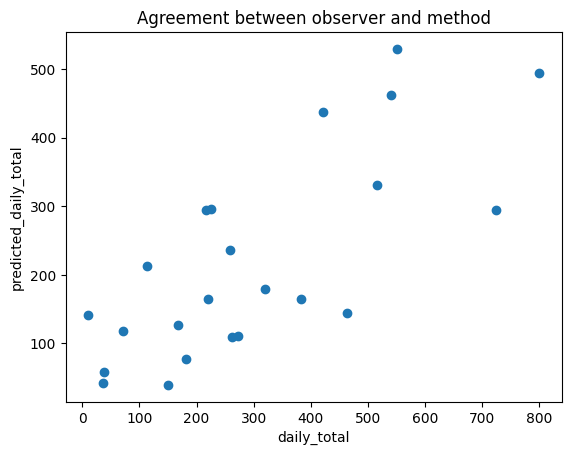

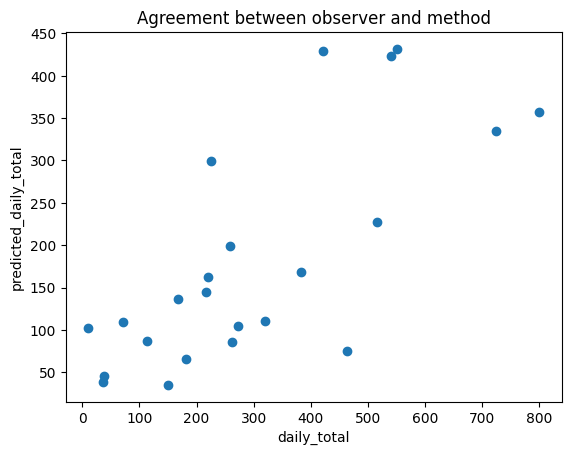

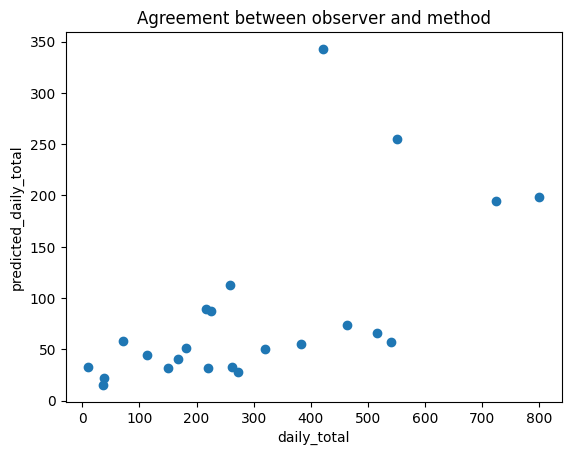

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier




# Split the data into a training set and a test set
data_test = test.index[test['start']>pd.to_datetime("2021-11-12 12:00:00",
                                                    format="%Y-%m-%d %H:%M:%S")]
data_train = test.index[test['start']<pd.to_datetime("2021-11-12 12:00:00",
                                                     format="%Y-%m-%d %H:%M:%S")]
train = train.loc[data_train]


# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']


# Define ids
ids = ['one_id','two_id','three_id','four_id']



train = ML_data2.copy()


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets].astype(int),
                                                    test_size=0.5,
                                                    random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




# Define the classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), random_state=42),
}



# Train and evaluate each model
for name, classifier in classifiers.items():
    print(f"Training {name}")



    # Create and train the multi-output model
    multi_target_classifier = MultiOutputClassifier(classifier, n_jobs=-1)
    multi_target_classifier.fit(X_train, y_train)

    # Use the model to make predictions
    predictions = multi_target_classifier.predict(X_test)


    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Print classification report for each target
    for i, target in enumerate(targets):
        print(f"Classification report for {target}:")
        print(classification_report(y_test.iloc[:, i], predictions[:, i]))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

    # Print average Jaccard score
    jaccard = jaccard_score(y_test, predictions, average='samples')
    print(f"Average Jaccard Score: {jaccard}")





    print('************************************************************')
    new_test = ML_data2.loc[data_test].copy()

    from sklearn.utils import shuffle
    new_test = shuffle(new_test,random_state=2)


    # Seperate X and y
    X_test = new_test.loc[:, features]
    y_test = new_test.loc[:, targets].astype(int)


    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Multi-output Random Forest
    #print("Training Multi-output Random Forest")
    #forest = RandomForestClassifier(random_state=1)
    #multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
    #multi_target_forest.fit(X_train, y_train)
    predictions = multi_target_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    # Print classification report for each target
    for i, target in enumerate(targets):
        print(f"Classification report for {target}:")
        print(classification_report(y_test.iloc[:, i], predictions[:, i]))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

    # Print average Jaccard score
    jaccard = jaccard_score(y_test, predictions, average='samples')
    print(f"Average Jaccard Score: {jaccard}")


    # Add the predictions as new columns to the test set DataFrame
    preds=[] #column names
    for i, target in enumerate(targets):
        ML_data2.loc[data_test, f"{target}_pred"] = predictions[:, i]
        preds.append(f"{target}_pred")


    # Determine the users from model output (binary)
    def get_predicted_users(row):
        return [row[id] for id, pred in zip(ids, preds) if row[pred] == 1]

    test.loc[data_test, 'predicted_user'] = ML_data2.loc[data_test].apply(get_predicted_users, axis=1)



    # calculate and visualize agreement
    cal_correlation(test.loc[data_test], 'event_ML_barcode')


In [ ]:
test=train.loc[data_test]


predictions = multi_target_forest.predict(test[features])


# Add the predictions as new columns to the test set DataFrame
preds=[] #column names
for i, target in enumerate(targets):
    train.loc[data_test, f"{target}_pred"] = predictions[:, i]
    preds.append(f"{target}_pred")



# Evaluate the model
accuracy = accuracy_score(y_test, test[targets].astype(int))
print(f"Accuracy: {accuracy}")

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")




# Determine the users from model output (binary)
def get_predicted_users(row):
    return [row[id] for id, pred in zip(ids, preds) if row[pred] == 1]

test.loc[data_test, 'predicted_user'] = ML_data.loc[data_test].apply(get_predicted_users, axis=1)



KeyError: ignored

event_ML_barcode
correlation =  nan


,predicted_daily_total,id,daily_total


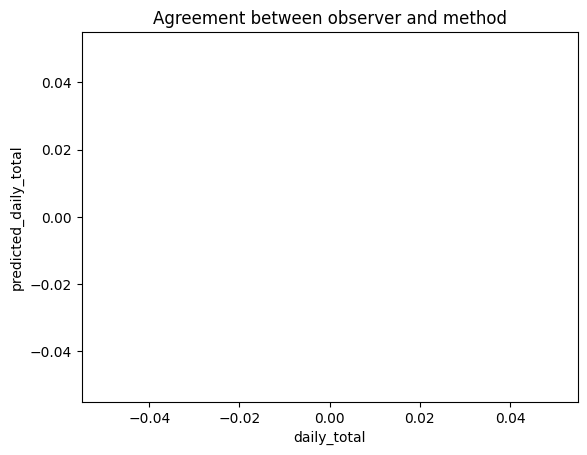

In [ ]:
cal_correlation(test.loc[data_test], 'event_ML_barcode')


##**RFID**

In [ ]:

train = pd.DataFrame(index=test.index,
                     columns =['one_t','two_t','three_t','four_t',
                               'one_is_user','two_is_user','three_is_user',
                               'four_is_user'] )

#train['one_id','two_id','three_id','four_id'] = ['','','','']


for i,row in test.iterrows():

  #Find the middle of the event
  target_time = test.loc[i,'start'] + test.loc[i,'duration']/2

  # Find the four closest cows
  closest = four_closest(target_time,rfid)

  # Time differences added to data ((as input to the ML))
  train.loc[i, ['one_t','two_t','three_t','four_t']] = closest['time_difference'].tolist()
  #train.loc[i, ['one_id','two_id','three_id','four_id']] = closest['ID']

  # check if each of the four cows are real users and create a binary list
  # accordingly (as output of the ML)
  binary_list = [1 if item in test.loc[i,'cow_id'] else 0 for item in closest['ID']]
  train.loc[i, ['one_is_user','two_is_user','three_is_user','four_is_user']] = binary_list





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))


# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets],
                                                    test_size=0.2,
                                                    random_state=42)

# Train a separate model for each output
for target in targets:
    print(f"Training model for {target}")

    # Create and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target].astype('int'))

    # Use the model to make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test[target].astype('int'), predictions)
    print(f"Accuracy: {accuracy}")

    evaluate_model(y_test[target].astype('int'), predictions)



Training model for one_is_user
Accuracy: 0.993949394939494
Confusion Matrix:
[[1117    6]
 [   5  690]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1123
           1       0.99      0.99      0.99       695

    accuracy                           0.99      1818
   macro avg       0.99      0.99      0.99      1818
weighted avg       0.99      0.99      0.99      1818

Training model for two_is_user
Accuracy: 0.9955995599559956
Confusion Matrix:
[[1750    2]
 [   6   60]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       0.97      0.91      0.94        66

    accuracy                           1.00      1818
   macro avg       0.98      0.95      0.97      1818
weighted avg       1.00      1.00      1.00      1818

Training model for three_is_user
Accuracy: 0.9983498349834984
Confusion Matrix:
[[1737    0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, jaccard_score
from keras.models import Sequential
from keras.layers import Dense



# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))


# Define the feature columns
features = ['one_t','two_t','three_t','four_t']

# Define the target columns
targets = ['one_is_user','two_is_user','three_is_user','four_is_user']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[targets].astype(int),
                                                    test_size=0.2,
                                                    random_state=42)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-output Random Forest
print("Training Multi-output Random Forest")
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)
predictions = multi_target_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))

# Print average Jaccard score
jaccard = jaccard_score(y_test, predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")

# Multi-output Neural Network
print("\nTraining Multi-output Neural Network")
model = Sequential()
model.add(Dense(10, input_dim=len(features), activation='relu'))
model.add(Dense(len(targets), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=0)

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Accuracy: {accuracy}')

# Neural network does not directly give discrete predictions,
#so we need to threshold the output
nn_predictions = (model.predict(X_test_scaled) > 0.5).astype(int)

# Print classification report for each target
for i, target in enumerate(targets):
    print(f"Classification report for {target}:")
    print(classification_report(y_test.iloc[:, i], nn_predictions[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test.iloc[:, i], predictions[:, i]))



# Print average Jaccard score
jaccard = jaccard_score(y_test, nn_predictions, average='samples')
print(f"Average Jaccard Score: {jaccard}")

Training Multi-output Random Forest
Accuracy: 0.9867986798679867
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1123
           1       0.99      0.99      0.99       695

    accuracy                           0.99      1818
   macro avg       0.99      0.99      0.99      1818
weighted avg       0.99      0.99      0.99      1818

Confusion Matrix:
[[1117    6]
 [   5  690]]
Classification report for two_is_user:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       0.97      0.91      0.94        66

    accuracy                           1.00      1818
   macro avg       0.98      0.95      0.97      1818
weighted avg       1.00      1.00      1.00      1818

Confusion Matrix:
[[1750    2]
 [   6   60]]
Classification report for three_is_user:
              precision    recall  f1-score   support

           0     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7101210355758667
57/57 [==============================] - 0s 1ms/step
Classification report for one_is_user:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1123
           1       0.73      0.86      0.79       695

    accuracy                           0.82      1818
   macro avg       0.82      0.83      0.82      1818
weighted avg       0.84      0.82      0.83      1818

Classification report for two_is_user:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1752
           1       1.00      0.17      0.29        66

    accuracy                           0.97      1818
   macro avg       0.98      0.58      0.64      1818
weighted avg       0.97      0.97      0.96      1818

Classification report for three_is_user:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1737
           1       0.64      0.17   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
